# 2023-hceres: HAL Data processing

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import unidecode
import json
import re
from typing import Any, Dict, List, Callable, Optional, Union, Pattern
import textwrap
import logging
import time, datetime
import os
import difflib

In [2]:
logging.basicConfig(
    format='[%(asctime)s][%(levelname)-5s][%(funcName)s#%(lineno)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO,
)
LOGGER = logging.getLogger(__name__)
LOGGER.info('Logger loaded')

[2023-03-26 10:59:55][INFO ][<module>#7] Logger loaded


# Definitions

## Constants

Define primary constants

* `LAB_STRUCT_ID` : The identifier in HAL of the CES (15080)
* `NON_ALPHA_NUMERIC_REGEX` : Regex to cleanup all non alpha numeric characters
* `JSON_FILENAME` : Extration from HAL API.
* `CURRENT_TIMESTAMP`: The current timestamp of the last run of this notebook (used to retrieve some refenrentials)


In [3]:
LAB_STRUCT_ID = 15080
NON_ALPHA_NUMERIC_REGEX = re.compile('[^a-z0-9_-]', re.IGNORECASE)
JSON_FILENAME = './result.2023-03-26T10-49.json'
CURRENT_TIMESTAMP = datetime.datetime.now().timestamp()

## Functions

In [4]:
# As an alternative, we might extends pandas the official way
# See: https://pandas.pydata.org/docs/development/extending.html#extending-pandas

class DfOps(pd.core.frame.DataFrame):
    
    def __init__(
        self,
        dataframe: pd.core.frame.DataFrame,
        prefix: Optional[str] = None
    ) -> None:
        super().__init__(dataframe)
        self._prefix = (prefix or '').strip('_ ')
    
    def _display(self, df: pd.core.frame.DataFrame) -> 'DfOps':
        import IPython.display as display
        display.display(df)
        return self

    def display(self) -> 'DfOps':
        return self._display(self)
    
    def display_head(self, n=5) -> 'DfOps':
        return self._display(self.head(n=n))
    
    def _target_file(self, filename:str, ext: str) -> str:
        target_file = f'{self._prefix}_{filename}'.strip('_ ')
        target_file = re.compile('[^a-z0-9\.-]+', re.IGNORECASE).sub('_', target_file)
        target_file = re.compile(f'\.{ext}$', re.IGNORECASE).sub('', target_file)
        target_file = f'./exports/{target_file}.{ext.lower()}'
        return target_file
        
    def csv(self, filename: str, index=True, **kwargs) -> 'DfOps':
        target_file = self._target_file(filename=filename, ext='csv')
        to_csv_params = { 'index': index, **kwargs }
        LOGGER.info("Export to CSV file: %s (params: %s) (number of rows: %d)", target_file, to_csv_params, len(self))
        self.to_csv(target_file, **to_csv_params)
        return self
    
    def count(self, subset: List[str], column: str, dropna: bool = False) -> 'DfOps':
        return DfOps(self.value_counts(subset=subset, dropna=dropna).to_frame(name=column).reset_index())
    
    def barh(
        self,
        x: str,
        y: str,
        title: str,
        sort_by: List[str] = [],
        plot_params: Dict[str, Any] = None,
        title_params: Dict[str, Any] = None,
        sort_params: Dict[str, Any] = None,
    ) -> 'DfOps':
        sort_by = sort_by or [ y ]
        plot_params = plot_params or {}
        title_params = title_params or {}
        sort_params = sort_params or {}
        
        result_sort_params = {**dict(by=sort_by, ascending=True), **sort_params}
        LOGGER.debug('Sort current dataframe for graph "%s" => sort_params=%s', title, result_sort_params)
        sorted_df = self.sort_values(**result_sort_params)
        
        result_plot_params = {
            **dict(legend=False, xlabel='', ylabel='', figsize=(8, 4), rot=0, fontsize=12), # Default params
            **plot_params, # Override params
            **dict(kind='barh', title=title, x=x) # Forced params
        }
        
        LOGGER.debug('Create barh graph for "%s" => plot_params=%s)', title, result_plot_params)
        p = sorted_df.plot(**result_plot_params)
        
        default_title_params = dict(pad=20, fontdict={'fontsize': 16})
        result_title_params = {**default_title_params, **title_params}
        LOGGER.debug('Set title "%s" of current barh graph => title_params=%s', title, result_title_params)
        p.set_title(title, **result_title_params)
        plt.tight_layout()
        
        target_file = self._target_file(filename=title, ext='png').lower()
        LOGGER.info("Export barh graph to PNG file: %s", target_file)
        p.get_figure().savefig(target_file, bbox_inches='tight')
        plt.show()
        
        return DfOps(sorted_df)
    
    def pie(
        self,
        label_column: str,
        column: str,
        title: str,
        sort_by: List[str] = [],
        plot_params: Dict[str, Any] = None,
        title_params: Dict[str, Any] = None,
        sort_params: Dict[str, Any] = None,
    ) -> 'DfOps':
        sort_by = sort_by or [ column ]
        plot_params = plot_params or {}
        title_params = title_params or {}
        sort_params = sort_params or {}
        
        result_sort_params = {**dict(by=sort_by), **sort_params}
        LOGGER.debug('Sort current dataframe for graph "%s" => sort_params=%s', title, result_sort_params)
        sorted_df = self.sort_values(**result_sort_params)
        
        result_plot_params = {
            **dict(
                subplots=True,
                sharex=False,
                sharey=False,
                labels=sorted_df[label_column],
                figsize=(12, 12),
                autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * self[column].sum() / 100)),
                pctdistance=0.8,
                legend=False,
            ),
            **plot_params,
            **dict(kind='pie', subplots=True, y=column)
        }
        LOGGER.debug('Create pie graph for "%s" => plot_params=%s)', title, result_plot_params)
        axs = sorted_df.plot(**result_plot_params)
        plt.tight_layout()
        axs[0].set_ylabel('')
        
        default_title_params = dict(y=1.0, pad=-14, fontdict={'fontsize': 16})
        result_title_params = {**default_title_params, **title_params}
        LOGGER.debug('Set title "%s" of current pie graph => title_params=%s', title, result_title_params)
        axs[0].set_title(title, **result_title_params)
        
        target_file = self._target_file(f'{title}.png', 'png').lower() 
        LOGGER.info("Export pie graph to PNG file: %s", target_file)
        plt.figure(1).savefig(target_file, bbox_inches='tight')
        plt.show() 
        return DfOps(sorted_df)

    def group_min_values(
        self,
        label_column: str,
        value_column: str = 'count',
        min_value: Union[float, int] = 0,
        min_label: Callable[[List[Any]], str] = lambda l: f'Others ({len(l)})',
        export_title: Optional[str] = None,
    ) -> 'DfOps':
        
        # Retrieve small dataframe to create a new 'others' row
        dataframe_others = self[(self[value_column] <= min_value)]
        dataframe_others_labels = dataframe_others[label_column].to_list()
        dateframe_others_sum = dataframe_others[value_column].sum()
        dataframe_others = pd.DataFrame(
            dict([
                (label_column, min_label(dataframe_others_labels)),
                (value_column, dateframe_others_sum)
            ]),
            index=[0]
        )
        LOGGER.info(
            'Create a new dataframe for other values (others=(col[\'%s\'] < %s]) => %d rows aggreated',
            value_column, str(min_value), len(dataframe_others_labels)
        )
        if export_title:
            DfOps(dataframe_others, prefix=f'{export_title}_grouped_{value_column}').csv(filename='others.csv', index=False) 
        
        # From base dataframe, retrieve the top values
        dataframe_top = self[(self[value_column] > min_value)]
        if export_title:
            DfOps(dataframe_top, prefix=f'{export_title}_grouped_{value_column}').csv(filename='top.csv', index=False) 
            
        # Concat the 2 DfOps
        dataframe_result = pd.concat([dataframe_top, dataframe_others], ignore_index=True)
        dataframe_result = DfOps(dataframe_result.sort_values(by=[value_column], ascending=False), prefix=f'{export_title or ""}_grouped_{value_column}')
        LOGGER.info('New dataframe size: %d (Original dataframe size: %d)', len(dataframe_result), len(self))
        if export_title:
            dataframe_result.csv(filename='all.csv', index=False) 
            
        return DfOps(dataframe_result)

#  Datasets

This dataset has been saved by another notebook : `extract-data-to-json.ipynb`

Here, we just load the data. For more information, see [./extract-data-to-json.ipynb](./extract-data-to-json.ipynb) another


## HAL APIs

### Load HAL API results

Load the HAP API results from filaneme named `JSON_FILENAME`

In [5]:
with open(JSON_FILENAME, 'r') as fp:
    data = json.load(fp)
df = pd.DataFrame.from_dict(data['response']['docs'])
df

,label_s,openAccess_bool,peerReviewing_s,audience_s,journalTitle_s,journalIssn_s,authLastName_s,authFirstName_s,authFullName_s,authIdFullName_fs,...,files_s,jel_s,keyword_s,funding_s,authStructId_i,europeanProjectAcronym_s,europeanProjectReference_s,anrProjectTitle_s,anrProjectAcronym_s,anrProjectReference_s
0,Claude Ménard. Will emerging local supply chai...,True,1,2,Zagadnienia Ekonomiki Rolnej / Problems of Agr...,0044-1600,[Ménard],[Claude],[Claude Ménard],[835588_FacetSep_Claude Ménard],...,[https://hal.science/hal-03534771/file/WILL%20...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Rémy Herrera, Zhiming Long, Zhixuan Feng, Bang...",False,1,2,Recherches Internationales,0294-3069,"[Herrera, Long, Feng, Li]","[Rémy, Zhiming, Zhixuan, Bangxi]","[Rémy Herrera, Zhiming Long, Zhixuan Feng, Ban...","[836621_FacetSep_Rémy Herrera, 0_FacetSep_Zhim...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Dominique Guégan, Thomas Renault. Does investo...",True,1,2,Finance Research Letters,1544-6123,"[Guégan, Renault]","[Dominique, Thomas]","[Dominique Guégan, Thomas Renault]","[0_FacetSep_Dominique Guégan, 0_FacetSep_Thoma...",...,[https://hal.science/hal-03205154/file/S154461...,"[G.G1.G12, G.G1.G14]","[Cryptocurrency, BitcoinInvestor sentiment, In...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Sophie Dessein, Corinne Perraudin, Nadine Thev...",False,1,2,NaN,NaN,"[Dessein, Perraudin, Thevenot]","[Sophie, Corinne, Nadine]","[Sophie Dessein, Corinne Perraudin, Nadine The...","[1160102_FacetSep_Sophie Dessein, 848277_Facet...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Agnès Penasse. Politique familiale : entre uni...,True,NaN,NaN,NaN,NaN,[Penasse],[Agnès],[Agnès Penasse],[1186934_FacetSep_Agnès Penasse],...,[https://theses.hal.science/tel-03852636/file/...,NaN,"[Family policy, Institutionalism, Universality...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,"Olivier Guéant, Jiang Pu. Mid-Price Estimation...",True,1,2,Market microstructure and liquidity,2382-6266,"[Guéant, Pu]","[Olivier, Jiang]","[Olivier Guéant, Jiang Pu]","[10375_FacetSep_Olivier Guéant, 0_FacetSep_Jia...",...,NaN,NaN,"[Bayesian filtering, Sequential Monte Carlo, M...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1605,Fatma Zahra Rostom. Sustainable metal extracti...,True,NaN,NaN,NaN,NaN,[Rostom],[Fatma Zahra],[Fatma Zahra Rostom],[748856_FacetSep_Fatma Zahra Rostom],...,[https://theses.hal.science/tel-02900661/file/...,NaN,"[Non-renewable natural resources, Metals, Mini...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1606,"Bruno Tinel. Trabalho, Força de trabalho e a d...",False,NaN,2,NaN,NaN,[Tinel],[Bruno],[Bruno Tinel],[12661_FacetSep_Bruno Tinel],...,NaN,NaN,NaN,NaN,[7550],NaN,NaN,NaN,NaN,NaN
1607,"Nicolas Jacquemet, Stéphane Luchini, Antoine M...",False,NaN,2,NaN,NaN,"[Jacquemet, Luchini, Malézieux]","[Nicolas, Stéphane, Antoine]","[Nicolas Jacquemet, Stéphane Luchini, Antoine ...","[12676_FacetSep_Nicolas Jacquemet, 742445_Face...",...,NaN,NaN,"[Fraude fiscale, Lutte contre, Economie politi...",NaN,[441569],NaN,NaN,NaN,NaN,NaN


### Stats

View some minor stats on non nan row for each columns

In [6]:
# List all non nan row for each columns
DfOps(df.count().to_frame()).csv('rows-having-values.csv', index=True)

[2023-03-26 10:59:55][INFO ][csv#35] Export to CSV file: ./exports/rows-having-values.csv (params: {'index': True}) (number of rows: 30)


,0
label_s,1609
openAccess_bool,1609
peerReviewing_s,872
audience_s,1070
journalTitle_s,897
journalIssn_s,838
authLastName_s,1609
authFirstName_s,1609
authFullName_s,1609
authIdFullName_fs,1609


## Authors Datasets

In this section, we will work on the authors to find all name forms.

This came from HAL Extractions.


### All authors (from HAL)...


In [7]:
# Cleanup useles columns for authors and explode on same list length
authors = df[['authLastName_s', 'authFirstName_s', 'authFullName_s']]
authors = authors.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s'])
authors = authors.drop_duplicates(ignore_index=True)
DfOps(authors).csv('authors-all.csv', index=False)

[2023-03-26 10:59:55][INFO ][csv#35] Export to CSV file: ./exports/authors-all.csv (params: {'index': False}) (number of rows: 1902)


,authLastName_s,authFirstName_s,authFullName_s
0,Ménard,Claude,Claude Ménard
1,Herrera,Rémy,Rémy Herrera
2,Long,Zhiming,Zhiming Long
3,Feng,Zhixuan,Zhixuan Feng
4,Li,Bangxi,Bangxi Li
...,...,...,...
1897,Proost,Stef,Stef Proost
1898,Li,Shan,Shan Li
1899,Zeng,Qingcheng,Qingcheng Zeng
1900,Issifou,Ismaël,Ismaël Issifou


### Current structure (from HAL)


As an author may have multiple structures, the number of items in `auth*` columns will not be the same !

We will have the same length in the following list :

* `authId_i`, `authLastName_s`, `authFirstName_s`, `authFullName_s`
* `authStructId_i`, `authIdHasPrimaryStructure_fs`

But the length of list `authId_i` and `authStructId_i` may be different.

We will use the facet `authIdHasPrimaryStructure_fs` to correlate an author with its `authStructId_i`.

At the end, we will produces 2 DataFrames:
* `struct_authors`: contains all the authors of the current structure
* `similarity_struct_authors`: contains all authors similarity

In [8]:
def fs_struct_authors(dataframe: pd.core.frame.DataFrame, column: str, pattern: Pattern) -> pd.core.frame.DataFrame:
    # Select only column of interest
    ndf = dataframe[['authFullName_s', 'authFirstName_s', 'authLastName_s', column]]
    ndf = ndf.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).explode([column]).drop_duplicates(ignore_index=True)
    ndf[[f'{column}_fullName', f'{column}_structId']] = ndf[column].str.extract(pattern)
    ndf = ndf.astype({f'{column}_structId': 'int'})
    # Correlate with authFullName_s
    ndf = ndf[ndf[f'{column}_fullName'] == ndf['authFullName_s']]
    # And structure id
    ndf = ndf[ndf[f'{column}_structId'] == LAB_STRUCT_ID]
    ndf = ndf.drop(columns=[column, f'{column}_fullName', f'{column}_structId']).drop_duplicates(ignore_index=True)
    return DfOps(ndf).csv(filename=f'authors-struct-{LAB_STRUCT_ID}-{column}.csv', index=False)

In [9]:
fs_auth_id_has_structure_authors = fs_struct_authors(
    dataframe=df,
    column='authIdHasStructure_fs',
    pattern=r'^.*_FacetSep_(?P<fullName>.*)_JoinSep_(?P<structId>\d+)_FacetSep_.*$'
)
fs_auth_id_has_primary_structure_authors = fs_struct_authors(
    dataframe=df,
    column='authIdHasPrimaryStructure_fs',
    pattern=r'^.*_FacetSep_(?P<fullName>.*)_JoinSep_(?P<structId>\d+)_FacetSep_.*$'
)
struct_authors = pd.concat([fs_auth_id_has_structure_authors, fs_auth_id_has_primary_structure_authors]) \
    .drop_duplicates(ignore_index=True) \
    .sort_values(by=['authLastName_s', 'authFirstName_s', 'authFullName_s']) \
    .reset_index(drop=True)
struct_authors = DfOps(struct_authors).csv('authors-struct-{LAB_STRUCT_ID}.csv', index=False)
struct_authors

[2023-03-26 10:59:55][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-15080-authIdHasStructure_fs.csv (params: {'index': False}) (number of rows: 399)
[2023-03-26 10:59:56][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-15080-authIdHasPrimaryStructure_fs.csv (params: {'index': False}) (number of rows: 398)
[2023-03-26 10:59:56][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-_LAB_STRUCT_ID_.csv (params: {'index': False}) (number of rows: 399)


,authFullName_s,authFirstName_s,authLastName_s
0,Joseph Abdou,Joseph,Abdou
1,Joseph M. Abdou,Joseph,Abdou
2,Eduardo Abi Jaber,Eduardo,Abi Jaber
3,Zeineb Affes,Zeineb,Affes
4,David Aguilar-Lleyda,David,Aguilar-Lleyda
...,...,...,...
394,Philippe de Peretti,Philippe,de Peretti
395,Elena L del Mercato,Elena,del Mercato
396,Elena del Mercato,Elena,del Mercato
397,Elena L. del Mercato,Elena L.,del Mercato


### Author names similarities (in HAL)

In [10]:
# will be better with faster with levenstein distance.
# Anyway, we will use what's in python builtin modules...
similarity_struct_authors = struct_authors.merge(struct_authors, how="cross", suffixes=('', '_alt')) # This will make a very big DataFrame !!
similarity_struct_authors = similarity_struct_authors[
    (similarity_struct_authors.authFullName_s != similarity_struct_authors.authFullName_s_alt)
    | (similarity_struct_authors.authLastName_s != similarity_struct_authors.authLastName_s_alt)
    | (similarity_struct_authors.authFirstName_s != similarity_struct_authors.authFirstName_s_alt)
]
similarity_struct_authors['similarity'] = similarity_struct_authors.apply(
    lambda r: difflib.SequenceMatcher(None, r['authFullName_s'], r['authFullName_s_alt']).ratio(), 
    axis=1
)
similarity_struct_authors = similarity_struct_authors.reset_index(drop=True)
DfOps(similarity_struct_authors[similarity_struct_authors.similarity > 0.8]).csv(f'authors-struct-{LAB_STRUCT_ID}-similarity-over-0.8.csv')

[2023-03-26 11:00:03][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-15080-similarity-over-0.8.csv (params: {'index': True}) (number of rows: 68)


,authFullName_s,authFirstName_s,authLastName_s,authFullName_s_alt,authFirstName_s_alt,authLastName_s_alt,similarity
0,Joseph Abdou,Joseph,Abdou,Joseph M. Abdou,Joseph,Abdou,0.888889
398,Joseph M. Abdou,Joseph,Abdou,Joseph Abdou,Joseph,Abdou,0.888889
994,Eduardo Abi Jaber,Eduardo,Abi Jaber,Eduardo Abi Jaber,Eduardo Abi,Jaber,1.000000
5586,Edith Archambault,Edith,Archambault,Édith Archambault,Édith,Archambault,0.941176
5984,Édith Archambault,Édith,Archambault,Edith Archambault,Edith,Archambault,0.941176
...,...,...,...,...,...,...,...
157606,Elena L del Mercato,Elena,del Mercato,Elena L. del Mercato,Elena L.,del Mercato,0.974359
158003,Elena del Mercato,Elena,del Mercato,Elena L del Mercato,Elena,del Mercato,0.944444
158004,Elena del Mercato,Elena,del Mercato,Elena L. del Mercato,Elena L.,del Mercato,0.918919
158401,Elena L. del Mercato,Elena L.,del Mercato,Elena L del Mercato,Elena,del Mercato,0.974359


## Authors external Datasets

From external CSV file, add some new columns to struct authors datasets.


In [11]:
# Load extra DataFrame
extra_ds_struct_authors = pd.read_csv('./cumul_producteurs_ces_2017_2022.csv', sep=';')
extra_ds_struct_authors.sort_values(by=['LASTNAME', 'FIRSTNAME'])
extra_ds_struct_authors['JOIN_LASTNAME_lower'] = extra_ds_struct_authors['JOIN_LASTNAME'].fillna("").str.lower()
extra_ds_struct_authors['JOIN_FIRSTNAME_lower'] = extra_ds_struct_authors['JOIN_FIRSTNAME'].fillna("").str.lower()
#DfOps(extra_right_struct_authors).display()

# Copy current struct authors DataFrame
extra_struct_authors = struct_authors.copy().reset_index(drop=True)
extra_struct_authors['authFirstName_s_lower'] = extra_struct_authors['authFirstName_s'].str.lower()
extra_struct_authors['authLastName_s_lower'] = extra_struct_authors['authLastName_s'].str.lower()
#DfOps(extra_struct_authors).display()

# Join extra_struct_authors with extra_ds_struct_authors
extra_struct_authors = extra_struct_authors.merge(
    extra_ds_struct_authors,
    how='outer',
    left_on=['authLastName_s_lower', 'authFirstName_s_lower'],
    right_on=['JOIN_LASTNAME_lower', 'JOIN_FIRSTNAME_lower']
)
#DfOps(extra_struct_authors).csv('authors-missing-producteurs_2017_2022.after-merged.csv')
extra_struct_authors = extra_struct_authors.drop(columns=[
    'JOIN_LASTNAME',
    'JOIN_FIRSTNAME',
    'JOIN_LASTNAME_lower',
    'JOIN_FIRSTNAME_lower',
    'authFirstName_s_lower',
    'authLastName_s_lower'
])

# Extract missing authors.
missing_extra_struct_authors = extra_struct_authors.copy()
#missing_extra_struct_authors = missing_extra_struct_authors[missing_extra_struct_authors['authFullName_s'].notnull()]
missing_extra_struct_authors = missing_extra_struct_authors.drop(columns=['authFullName_s'])
missing_extra_struct_authors = missing_extra_struct_authors.rename(columns={'authLastName_s': 'JOIN_LASTNAME', 'authFirstName_s': 'JOIN_FIRSTNAME'})
missing_extra_struct_authors = missing_extra_struct_authors.sort_values(by=['JOIN_LASTNAME', 'JOIN_FIRSTNAME'])
missing_extra_struct_authors = missing_extra_struct_authors[['POSTE', 'JOIN_LASTNAME', 'JOIN_FIRSTNAME', 'LASTNAME', 'FIRSTNAME']]
DfOps(missing_extra_struct_authors).csv('authors-missing-producteurs_2017_2022.csv', index=False)

# Create final result for extra_struct_authors
extra_struct_authors['POSTE'] = extra_struct_authors['POSTE'].fillna('OTHERS').str.upper()
extra_struct_authors

[2023-03-26 11:00:03][INFO ][csv#35] Export to CSV file: ./exports/authors-missing-producteurs_2017_2022.csv (params: {'index': False}) (number of rows: 551)


,authFullName_s,authFirstName_s,authLastName_s,POSTE,LASTNAME,FIRSTNAME
0,Joseph Abdou,Joseph,Abdou,PERMANENT,ABDOU,Joseph
1,Joseph M. Abdou,Joseph,Abdou,PERMANENT,ABDOU,Joseph
2,Eduardo Abi Jaber,Eduardo,Abi Jaber,PERMANENT,ABI JABER,Eduardo
3,Zeineb Affes,Zeineb,Affes,DOCTORANT,AFFES,Zeineb
4,David Aguilar-Lleyda,David,Aguilar-Lleyda,OTHERS,AGUILAR-LLEYDA,Davide
...,...,...,...,...,...,...
546,NaN,NaN,NaN,DOCTORANT,DECHAUX,Pierrick
547,NaN,NaN,NaN,DOCTORANT,LONG,Zhiming
548,NaN,NaN,NaN,DOCTORANT,MONASTYRENKO,Evgenii
549,NaN,NaN,NaN,OTHERS,MYCZKOWSKI,Alix


In [12]:
extra_struct_authors_stat = extra_struct_authors[['POSTE', 'LASTNAME' , 'FIRSTNAME']].drop_duplicates(ignore_index=True)
extra_struct_authors_stat['POSTE'].value_counts().to_frame('EFFECTIF').reset_index()

,index,EFFECTIF
0,DOCTORANT,208
1,PERMANENT,135
2,EMERITE,33
3,ASSOCIE,23
4,OTHERS,16


## Rerefentials Datasets

In [13]:
# datetime.timedelta(days=1).total_seconds() = 86400
def download_referential(target_file: str, ref_url: str, delta: int = 86400):
    mtime = 0
    if os.path.exists(target_file):
        mtime = os.path.getmtime(target_file)

    LOGGER.info('%s modification time %d (current timestamp: %d)', target_file, mtime, CURRENT_TIMESTAMP)

    if CURRENT_TIMESTAMP - mtime > delta:
        LOGGER.info('Download %s referential at %s', target_file, ref_url)
        resp = requests.get(ref_url);
        resp.status_code
        if resp.status_code == 200:
            with open(target_file, 'wb') as fd:
                fd.write(resp.content)
            LOGGER.info('URL Content %s has been saved to file: %s', ref_url, target_file)
        else:
            LOGGER.error('Cannot retrieve file %s. Status Code: %d', target_file, resp.status_code)
    else:
        LOGGER.info('Skipping download of file %s as it has been modified %d seconds ago', target_file, max(0, CURRENT_TIMESTAMP - mtime))

### Econlit

EconLit referential is available at https://www.aeaweb.org/econlit/journal_list.php .

#### HTML Parsing

A JSON Datasets can be extract from a web browser (such as Chrome or Firefox) using the simple following commands in a web console:

```javascript
$$('.journaldesc')
  .map(item => $(item).text().split('\n'))
  .map(arr => Object.assign(
    { Title: arr[0].trim() },
    Object.fromEntries(
      arr
      .slice(1)
      .map(val => val.trim())
      .map(line => [
        line.split(':', 1).join().trim(),
        line.split(':').slice(1).join(':').trim()
      ]))
  ));
```

This will extract all the required code in a object that can be copy/paste into a JSON file

**Note 1 :** It's possible to have some ISSN duplicated here. For example, `0013-0117` have several titles (_Economic History Review_ or _Economic History Review, Second Series_)

**Note 2 :** For formating purpose, `$$` should be replace with a single `$`

#### CSV Export

For a long time, it wasn't possible to retrieve an export of the Econlit referential. So, we did it using a simple javasript export ! Even if it was working pretty well, Econlit evolved and now we have a real CSV export of the Econlit referential.

In [14]:
download_referential(target_file='./ref.econlit.csv', ref_url='https://www.aeaweb.org/journals/econlit-journals/export')

[2023-03-26 11:00:03][INFO ][download_referential#7] ./ref.econlit.csv modification time 1679827812 (current timestamp: 1679828395)
[2023-03-26 11:00:03][INFO ][download_referential#20] Skipping download of file ./ref.econlit.csv as it has been modified 583 seconds ago


In [15]:
econlit_df = pd.read_csv('./ref.econlit.csv').drop(columns=['EconLit Coverage', 'Formerly', 'See']).rename(columns={'Name': 'Title'})
LOGGER.info('Econlit original size : %d', econlit_df["Title"].size)
# Cleaning data
#econlit_df['ISSN'] = econlit_df['ISSN'].transform(lambda x: x.strip())
econlit_df = econlit_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
LOGGER.info('Econlit size after droping duplicates : %d', econlit_df["Title"].size)
econlit_df

[2023-03-26 11:00:03][INFO ][<module>#2] Econlit original size : 2036
[2023-03-26 11:00:03][INFO ][<module>#6] Econlit size after droping duplicates : 1908


,Title,URL,ISSN
0,4OR: A Quarterly Journal of Operations Research,https://link.springer.com/journal/volumesAndIs...,1619-4500
1,Academia Economic Papers,https://www.econ.sinica.edu.tw/posts/137,1018-161X
2,"Accounting, Business and Financial History",NaN,0958-5206
3,"Accounting, Economics, and Law: A Convivium",http://www.degruyter.com/view/j/ael,2194-6051
4,Accounting History Review,http://www.tandfonline.com/loi/rabf21,2155-2851
...,...,...,...
1903,Zeitschrift für Wirtschafts- und Sozialwissens...,NaN,0342-1783
1904,Zeitschrift für Wirtschafts- und Unternehmense...,NaN,1439-880X
1905,Zeitschrift für Wirtschaftspolitik,https://www.degruyter.com/journal/key/zfwp/html,0721-3808
1906,Zhournal Novoi Ekonomicheskoi Associacii/Journ...,http://www.econorus.org/enjarchive.phtml,2221-2264


### MathSciNet

MathSciNet referential is available at https://mathscinet.ams.org/mathscinet/mrcit/journal_list.html


#### HTML Parsing

A JSON Datasets can be extract from browser using the simple following commands in a web console:

```javascript
$$('table tr')
  .map(i => $(i).find('td'))
  .filter(a => a.length === 4)
  .map(a => ({
    ISSN: $(a[0]).text().trim(),
    Title: $(a[1]).text().trim(),
    Publisher: $(a[2]).text().trim(),
    Start_Year: $(a[3]).text().trim()
  }))
```

**Note 1:** We may have duplicates in `ISSN` columns

In [16]:
mathscinet_df = pd.read_json('./ref.mathscinet.json').drop(columns=['Publisher', 'Start_Year'])
print(f'MathSciNet original size : {mathscinet_df["Title"].size}')
mathscinet_df['ISSN'] = mathscinet_df['ISSN'].transform(lambda x: x.strip())
mathscinet_df = mathscinet_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
print(f'MathSciNet size after cleaning duplicates : {mathscinet_df["Title"].size}')
mathscinet_df

MathSciNet original size : 765
MathSciNet size after cleaning duplicates : 617


,ISSN,Title
0,0271-4132,Contemp. Math.
1,0302-9743,Lecture Notes in Comput. Sci.
2,0160-7634,Proc. Sympos. Appl. Math.
3,0082-0717,Proc. Sympos. Pure Math.
4,0025-5858,Abh. Math. Semin. Univ. Hambg.
...,...,...
612,0165-2125,Wave Motion
613,0044-2267,ZAMM Z. Angew. Math. Mech.
614,0232-2064,Z. Anal. Anwend.
615,0044-2275,Z. Angew. Math. Phys.


### Scimago JCR

A CSV is already available on the [scimago website](https://www.scimagojr.com/journalrank.php) and can be donwload with the following links: https://www.scimagojr.com/journalrank.php?out=xls


**Note :** The `Issn` columns may contains multiples ISSN 

In [17]:
download_referential(target_file='./ref.scimagojr_2021.csv', ref_url='https://www.scimagojr.com/journalrank.php?out=xls')

[2023-03-26 11:00:03][INFO ][download_referential#7] ./ref.scimagojr_2021.csv modification time 1679827814 (current timestamp: 1679828395)
[2023-03-26 11:00:03][INFO ][download_referential#20] Skipping download of file ./ref.scimagojr_2021.csv as it has been modified 580 seconds ago


In [18]:
scimagojr_df = pd.read_csv('./ref.scimagojr_2021.csv', sep=';')[['Title', 'Issn', 'Categories', 'SJR Best Quartile']]
scimagojr_df = scimagojr_df.rename(columns={'Issn': 'ISSNs', 'SJR Best Quartile': 'SJR_BEST_QUARTILE', 'Categories': 'CATEGORIES'})
LOGGER.info('Scimago original size: %d', scimagojr_df["Title"].size)

scimagojr_df['ISSN'] = scimagojr_df['ISSNs'].apply(lambda x: x.split(','))
scimagojr_df = scimagojr_df.explode('ISSN')
LOGGER.info('Scimago size after exploding "ISSNs" columns: %d', scimagojr_df["Title"].size)

scimagojr_df['ISSN'] = scimagojr_df['ISSN'].transform(lambda x: '-'.join(textwrap.wrap(x.strip(),4)))
scimagojr_df = scimagojr_df.drop(columns=['ISSNs']).drop_duplicates(subset=['ISSN'], ignore_index=True)
LOGGER.info('Scimago size after exploding "ISSNs" and droping duplicates: %d', scimagojr_df["Title"].size)

scimagojr_df

[2023-03-26 11:00:03][INFO ][<module>#3] Scimago original size: 27339
[2023-03-26 11:00:03][INFO ][<module>#7] Scimago size after exploding "ISSNs" columns: 43410
[2023-03-26 11:00:03][INFO ][<module>#11] Scimago size after exploding "ISSNs" and droping duplicates: 43369


,Title,CATEGORIES,SJR_BEST_QUARTILE,ISSN
0,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,1542-4863
1,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,0007-9235
2,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0072
3,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0080
4,Quarterly Journal of Economics,Economics and Econometrics (Q1),Q1,0033-5533
...,...,...,...,...
43364,WSEAS Transactions on Information Science and ...,Computer Science Applications; Information Sys...,-,1790-0832
43365,WSEAS Transactions on Systems,Computer Science Applications; Control and Sys...,-,1109-2777
43366,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,2544-8730
43367,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,1897-0788


### HCERES Vague B 2021


#### PDF Export

Arf, this is most painfull format (a old school PDF) ! This should be done (almost) manually...

The current file is available here:
https://www.hceres.fr/sites/default/files/media/downloads/hceres_2021_liste_domaine_shs1_economie_et_gestion.pdf

**Steps :**

* Extract a flat text of the PDF
* Remove useles data such as the presentation, the page numbers, ...
* Replace using regex :
  * Searched: `^(.{9})\s+(.*)\s+([^\s]+)\s+([^\s]+)\s+([^\s]+)\s?$`
  * Replacement: `{"ISSN":"$1", "Title": "$2", "CoNRS_2020": "$3"; "FNEGE_2019": "$4", "HCERES_2021": "$5" },`
* Remove the `,` char at the end of the document
* Append `[` char at the beginning and `]` at the end of the document

**Note :** We may have duplicates in `ISSN` columns

In [19]:
hceres_df = pd.read_json('./ref.hceres.json')
LOGGER.info('HCERES original size: %d', hceres_df["Title"].size)

hceres_df['ISSN'] = hceres_df['ISSN'].transform(lambda x: x.strip())
hceres_df = hceres_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
hceres_df = hceres_df.replace('-', np.nan)
LOGGER.info('HCERES size after cleaning duplicates: %d', mathscinet_df["Title"].size)

hceres_df

[2023-03-26 11:00:04][INFO ][<module>#2] HCERES original size: 937
[2023-03-26 11:00:04][INFO ][<module>#7] HCERES size after cleaning duplicates: 617


,ISSN,Title,CoNRS_2020,FNEGE_2019,HCERES_2021
0,2034-9130,@GRH,NaN,3,B
1,1619-4500,4OR: A Quarterly Journal of Operations Research,3,NaN,B
2,0001-3072,Abacus,3,2,A
3,1941-6520,Academy of Management Annals,2,1,A
4,0001-4273,Academy of Management Journal,1,1,A
...,...,...,...,...,...
919,1011-4548,World Competition. Law and Economics Review,3,NaN,B
920,0305-750X,World Development,1,NaN,A
921,0378-5920,World Economy,2,NaN,A
922,1474-7456,World Trade Review,4,NaN,C


# All documents types

## Document type distribution

[2023-03-26 11:00:04][INFO ][csv#35] Export to CSV file: ./exports/document_types.csv (params: {'index': False}) (number of rows: 11)
[2023-03-26 11:00:04][INFO ][barh#77] Export barh graph to PNG file: ./exports/distribution_by_types.png


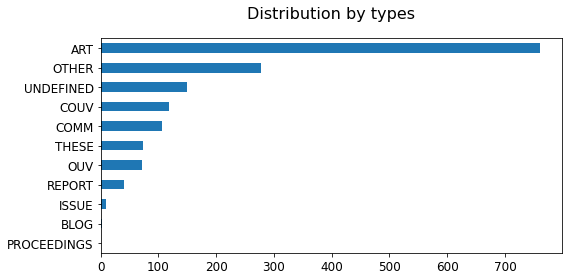

[2023-03-26 11:00:04][INFO ][<module>#5] Number of document without docType_s: 0
[2023-03-26 11:00:04][INFO ][<module>#6] Number of document types: 11


,docType_s,count
10,PROCEEDINGS,1
9,BLOG,2
8,ISSUE,9
7,REPORT,40
6,OUV,72
5,THESE,73
4,COMM,106
3,COUV,118
2,UNDEFINED,150
1,OTHER,278


In [20]:
doc_types = DfOps(df) \
    .count(subset=['docType_s'], column='count') \
    .csv('document_types.csv', index=False) \
    .barh(title='Distribution by types', x='docType_s', y='count')
LOGGER.info('Number of document without docType_s: %d', doc_types[doc_types.docType_s.isnull()]["count"].sum())
LOGGER.info('Number of document types: %d', doc_types["docType_s"].dropna().size)
doc_types

In [21]:
doc_types_others = DfOps(doc_types).group_min_values(
    label_column = 'docType_s',
    value_column = 'count',
    min_value = 40,
    min_label = lambda l: f'{" + ".join(l)}'
)
doc_types_others

[2023-03-26 11:00:04][INFO ][group_min_values#152] Create a new dataframe for other values (others=(col['count'] < 40]) => 4 rows aggreated
[2023-03-26 11:00:04][INFO ][group_min_values#167] New dataframe size: 8 (Original dataframe size: 11)


,docType_s,count
6,ART,760
5,OTHER,278
4,UNDEFINED,150
3,COUV,118
2,COMM,106
1,THESE,73
0,OUV,72
7,PROCEEDINGS + BLOG + ISSUE + REPORT,52


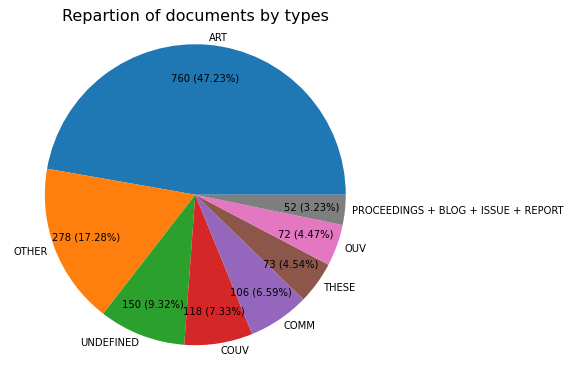

In [22]:
axs = doc_types_others['count'].plot(
    kind='pie',
    subplots=True,
    sharex=False,
    sharey=False,
    #title='Occurence',
    labels=doc_types_others['docType_s'],
    figsize=(8, 8),
    #autopct='%1.1f%%',
    autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * doc_types_others['count'].sum() / 100)),
    pctdistance=0.78,
    #rotatelabels=False,
    labeldistance=1.05
)
plt.tight_layout()
#plt.figure(1).savefig(occurence_png_target_file)
axs[0].set_ylabel('')
axs[0].set_title('Repartion of documents by types', y=1.0, pad=-14, fontdict={'fontsize': 16})
plt.figure(1).savefig(f'./exports/document_types_distribution_pie.png', bbox_inches='tight')
plt.show()

## Audiences

In [23]:
audience_values = {
    '1': 'NOT_SPECIFIED',
    '2': 'INTERNATIONAL',
    '3': 'NATIONAL',
}

audiences = df['audience_s'].apply(lambda x: audience_values.get(str(x or '1'), 'NOT_SPECIFIED')).to_frame()
audiences = audiences[['audience_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
audiences

,audience_s,count
0,INTERNATIONAL,1031
1,NOT_SPECIFIED,546
2,NATIONAL,32


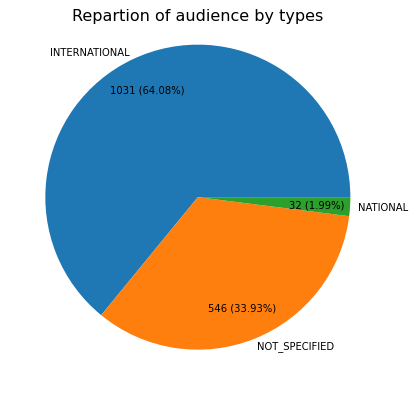

In [24]:
axs = audiences['count'].plot(
    kind='pie',
    subplots=True,
    sharex=False,
    sharey=False,
    #title='Occurence',
    labels=audiences['audience_s'],
    figsize=(6, 6),
    #autopct='%1.1f%%',
    autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * audiences['count'].sum() / 100)),
    pctdistance=0.78,
    #rotatelabels=False,
    labeldistance=1.05
)
plt.tight_layout()
#plt.figure(1).savefig(occurence_png_target_file)
axs[0].set_ylabel('')
axs[0].set_title('Repartion of audience by types', y=1.0, pad=-14, fontdict={'fontsize': 16})
plt.figure(1).savefig(f'./exports/audience_distribution_pie.png', bbox_inches='tight')
plt.show()

# Articles : Data Processing

In [25]:
df_art = df[df['docType_s'] == 'ART'].drop(columns=['docType_s']).reset_index(drop=True)
df_art

,label_s,openAccess_bool,peerReviewing_s,audience_s,journalTitle_s,journalIssn_s,authLastName_s,authFirstName_s,authFullName_s,authIdFullName_fs,...,files_s,jel_s,keyword_s,funding_s,authStructId_i,europeanProjectAcronym_s,europeanProjectReference_s,anrProjectTitle_s,anrProjectAcronym_s,anrProjectReference_s
0,Claude Ménard. Will emerging local supply chai...,True,1,2,Zagadnienia Ekonomiki Rolnej / Problems of Agr...,0044-1600,[Ménard],[Claude],[Claude Ménard],[835588_FacetSep_Claude Ménard],...,[https://hal.science/hal-03534771/file/WILL%20...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Rémy Herrera, Zhiming Long, Zhixuan Feng, Bang...",False,1,2,Recherches Internationales,0294-3069,"[Herrera, Long, Feng, Li]","[Rémy, Zhiming, Zhixuan, Bangxi]","[Rémy Herrera, Zhiming Long, Zhixuan Feng, Ban...","[836621_FacetSep_Rémy Herrera, 0_FacetSep_Zhim...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Dominique Guégan, Thomas Renault. Does investo...",True,1,2,Finance Research Letters,1544-6123,"[Guégan, Renault]","[Dominique, Thomas]","[Dominique Guégan, Thomas Renault]","[0_FacetSep_Dominique Guégan, 0_FacetSep_Thoma...",...,[https://hal.science/hal-03205154/file/S154461...,"[G.G1.G12, G.G1.G14]","[Cryptocurrency, BitcoinInvestor sentiment, In...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Rémy Herrera, Zhiming Long, Weinan Ding. Éléme...",False,1,2,Recherches Internationales,0294-3069,"[Herrera, Long, Ding]","[Rémy, Zhiming, Weinan]","[Rémy Herrera, Zhiming Long, Weinan Ding]","[836621_FacetSep_Rémy Herrera, 0_FacetSep_Zhim...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Christophe Ramaux. ""Les leçons du covid : comm...",False,1,2,Recherches Internationales,0294-3069,[Ramaux],[Christophe],[Christophe Ramaux],[845253_FacetSep_Christophe Ramaux],...,NaN,[I.I1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Laurine Martinoty. Partner’s income shock and ...,False,1,2,World Development,0305-750X,[Martinoty],[Laurine],[Laurine Martinoty],[11790_FacetSep_Laurine Martinoty],...,[https://hal.science/hal-03767916/file/WD_revi...,"[D.D1.D10, J.J2.J22, O.O1.O12, O.O5.O54]","[Female labor force, Female employment, Intra-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,Olivier Guéant. Optimal execution of accelerat...,True,1,2,The Journal of Risk,1465-1211,[Guéant],[Olivier],[Olivier Guéant],[10375_FacetSep_Olivier Guéant],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,"Jérôme Valette, Sekou Keita. Natives’ Attitude...",True,1,2,Demography,0070-3370,"[Valette, Keita]","[Jérôme, Sekou]","[Jérôme Valette, Sekou Keita]","[734820_FacetSep_Jérôme Valette, 0_FacetSep_Se...",...,NaN,NaN,"[Immigrant workers, Unemployment duration, Dis...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
758,"Olivier Guéant, Jiang Pu. Mid-Price Estimation...",True,1,2,Market microstructure and liquidity,2382-6266,"[Guéant, Pu]","[Olivier, Jiang]","[Olivier Guéant, Jiang Pu]","[10375_FacetSep_Olivier Guéant, 0_FacetSep_Jia...",...,NaN,NaN,"[Bayesian filtering, Sequential Monte Carlo, M...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Keywords

Count the number of keywords for all articles

In [26]:
keywords = df_art.explode('keyword_s')
keywords = keywords[['keyword_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
keywords.to_csv(path_or_buf='./exports/keywords.csv', index=False)
LOGGER.info('Number of articles without keywords: %d', keywords[keywords.keyword_s.isnull()]["count"].sum())
LOGGER.info('Number of keywords: %d', keywords["keyword_s"].dropna().size)
keywords.head(n=5)

[2023-03-26 11:00:04][INFO ][<module>#4] Number of articles without keywords: 270
[2023-03-26 11:00:04][INFO ][<module>#5] Number of keywords: 2091


,keyword_s,count
0,NaN,270
1,France,18
2,Metacognition,10
3,Confidence,10
4,China,9


In [27]:
top_count_keywords = keywords.dropna()
top_count_keywords = top_count_keywords[top_count_keywords['count'] >= 4].sort_values(by=['count']).reset_index().sort_values(by=['count'], ascending=False)
top_count_keywords

,index,keyword_s,count
43,1,France,18
42,2,Metacognition,10
41,3,Confidence,10
40,4,China,9
39,5,Regulation,9
38,6,Governance,9
37,7,Inequality,8
36,8,Institutions,8
33,10,Redistribution,7
32,9,Malaria,7


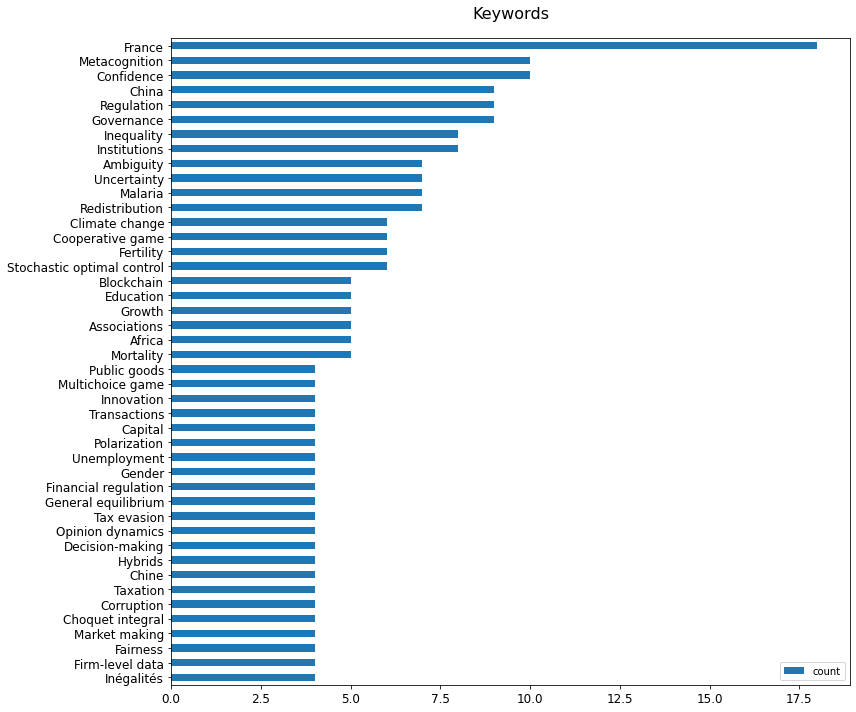

In [28]:
p = top_count_keywords.sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Keywords',
    x='keyword_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 10),
    rot=0,
    fontsize=12
)
p.set_title('Keywords', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/keywords_repartition.png', bbox_inches='tight')

## Journals

### Journals occurrences 

In [29]:
journals = df_art[['journalTitle_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
journals.to_csv(path_or_buf='./exports/journals.csv', index=False)
LOGGER.info('Number of journals : %d', journals["journalTitle_s"].size)
journals.head(n=5)

[2023-03-26 11:00:05][INFO ][<module>#3] Number of journals : 397


,journalTitle_s,count
0,Revue Economique,17
1,Journal of Mathematical Economics,17
2,Journal of Economic Behavior and Organization,12
3,Economic Theory,10
4,Revue française des affaires sociales,9


In [30]:
top_count_journals = journals[journals['count'] >= 4].sort_values(by=['count'], ascending=False)
top_count_journals

,journalTitle_s,count
0,Revue Economique,17
1,Journal of Mathematical Economics,17
2,Journal of Economic Behavior and Organization,12
3,Economic Theory,10
4,Revue française des affaires sociales,9
5,Scientific Reports,8
6,Socio-économie du travail,8
7,Theory and Decision,7
8,Revue d'Economie Politique,7
9,Mathematical Social Sciences,7


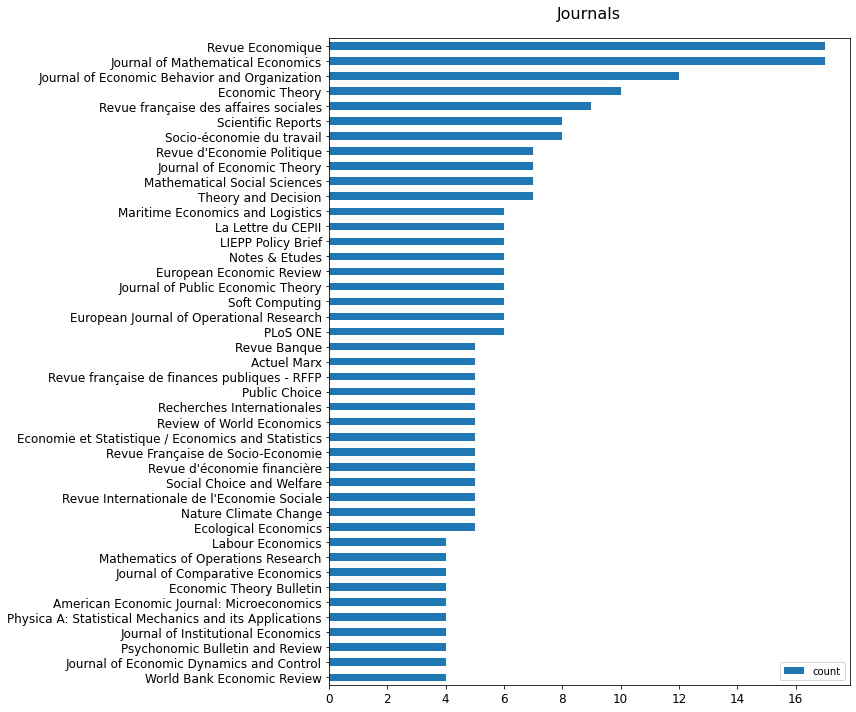

In [31]:
p = top_count_journals.sort_values(by=['count']).plot(
    kind='barh',
    title='Journals',
    x='journalTitle_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 10),
    fontsize=12
)
p.set_title('Journals', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/journals_repartition.png', bbox_inches='tight')

### Journal without ISSN

In [32]:
journal_without_issns = df_art[df_art.journalIssn_s.isnull()][['uri_s', 'journalTitle_s']].reset_index(drop=True)
journal_without_issns.to_csv(f'./exports/journals_without_issn.csv', index=False)
journal_without_issns

,uri_s,journalTitle_s
0,https://hal.science/hal-02877569v4,SIAM Journal on Financial Mathematics
1,https://hal.science/hal-03973503,Notes & Etudes
2,https://hal-sciencespo.archives-ouvertes.fr/ha...,LIEPP Policy Brief
3,https://shs.hal.science/halshs-01674689,BMJ Global Health
4,https://hal.science/hal-03973713,Notes & Etudes
5,https://hal.science/hal-03968639,Notes & Etudes
6,https://hal.science/hal-03233303,政治经济学与当代问题
7,https://hal.science/hal-03680071,SIAM Journal on Financial Mathematics
8,https://hal.science/hal-01492508,Neuroscience of Consciousness
9,https://hal.science/hal-04003982,Les notes du conseil d'analyse économique


## JEL

In [33]:
# Number of Non NA Values
df_art[['uri_s', 'jel_s']].count()

uri_s    760
jel_s    282
dtype: int64

In [34]:
jels = df_art[['uri_s', 'jel_s']].explode('jel_s')
jels.to_csv(path_or_buf='./exports/jels.csv', index=False)
jels = jels.dropna()
jels

,uri_s,jel_s
2,https://hal.science/hal-03205154,G.G1.G12
2,https://hal.science/hal-03205154,G.G1.G14
4,https://hal.science/hal-03912939,I.I1
5,https://hal.science/hal-03774313,B.B2
5,https://hal.science/hal-03774313,B.B2.B22
...,...,...
759,https://hal.science/hal-02974389,E.E2.E22
759,https://hal.science/hal-02974389,J.J2.J24
759,https://hal.science/hal-02974389,N.N1.N15
759,https://hal.science/hal-02974389,O.O1.O11


In [35]:
jels['jel_s_code'] = jels['jel_s'].apply(lambda x: x.split('.')[0])
count_jels = jels.value_counts(subset=['jel_s_code']).to_frame(name='count').reset_index()
count_jels

,jel_s_code,count
0,D,195
1,C,153
2,J,87
3,E,68
4,O,68
5,G,65
6,F,55
7,H,45
8,L,38
9,B,35


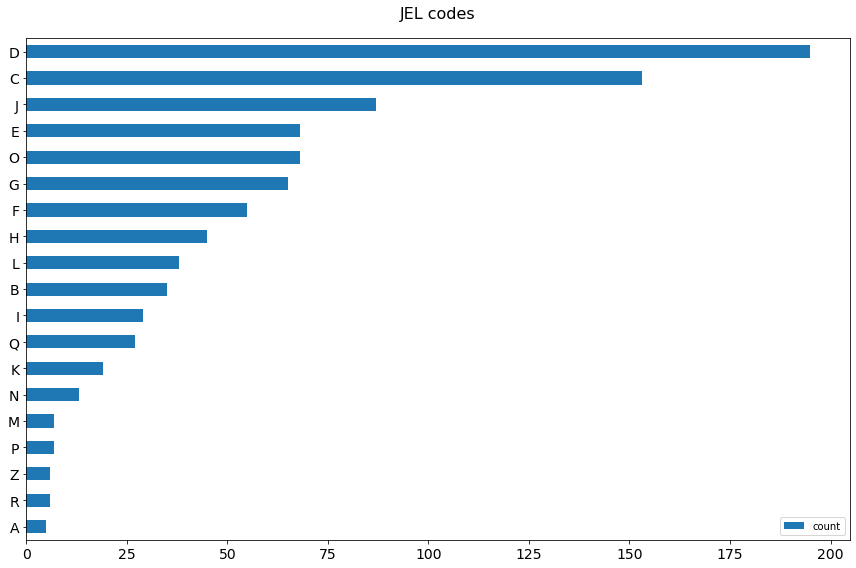

In [36]:
p = count_jels.sort_values(by=['count']).plot(
    kind='barh',
    title='JEL',
    x='jel_s_code',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 8),
    fontsize=14,
    rot=0,
)
p.set_title('JEL codes', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/jel_first_level_repartition.png', bbox_inches='tight')

## Funding

In [37]:
def funding_stats(dataframe: pd.core.frame.DataFrame,
                  filename: str,
                  columns: List[str],
                  occurence_params: Dict[str, Any] = dict(),
                  occurence_title_params: Dict[str, Any] = dict(),
                  repartition_params: Dict[str, Any] = dict(),
                  repartition_title_params: Dict[str, Any] = dict(),
                  repartition_group_min: int = 0):
    LOGGER.info(f'Start processing funding for output filename "%s" based on columns: %s', filename, columns)
    
    # Extract dataframe data
    exploded = dataframe.explode(columns)
    exploded = exploded[['uri_s'] + columns]
    DfOps(exploded.dropna()).csv(filename=f'fundings_{filename}_uri.csv', index=False)
    
    # Occurences stats
    occurence_exploded = exploded[columns].value_counts(dropna=True).to_frame(name='count').reset_index()
    DfOps(occurence_exploded).csv(filename=f'fundings_{filename}_occurence.csv', index=False)
    if not occurence_exploded.empty:
        occurence_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Occurence',
            ylabel='',
            labels=occurence_exploded[columns[0]],
            figsize=(12, 12),
            autopct='%1.1f%%',
            pctdistance=0.85,
            rotatelabels=True,
            labeldistance=1.02,
        )
        occurence_params = { **occurence_default_params, **occurence_params }
        axs = occurence_exploded['count'].plot(**{ **occurence_params, 'title': None })
        plt.tight_layout()
        axs[0].set_ylabel('')
        axs[0].set_title(**{
            **dict(
                label=occurence_params['title'],
                y=1.0,
                pad=-14,
                fontdict={'fontsize': 16}
            ),
            **occurence_title_params
        })
        occurence_png_target_file = f'./exports/fundings_{filename}_occurence.png' 
        plt.figure(1).savefig(occurence_png_target_file, bbox_inches='tight')
        plt.show()
        LOGGER.info('Saving figure to "%s"', occurence_png_target_file)
    else:
        LOGGER.info('Skip figure of occurence for "%s" as the dataframe is empty', filename)
        
    
    # Repartition of having value
    count_exploded = exploded.dropna()[['uri_s']].value_counts().to_frame(name='count').reset_index()
    count_exploded = dataframe.merge(count_exploded, how='left', on='uri_s')
    count_exploded = count_exploded[['uri_s', 'count']].fillna(0).astype({'count': int}).drop_duplicates()
    DfOps(count_exploded).csv(filename=f'fundings_{filename}_count.csv', index=False)
    
    repartition_count_exploded = count_exploded[['count']].value_counts().to_frame(name='number_of_count').reset_index()
    DfOps(repartition_count_exploded).csv(filename=f'fundings_{filename}_repartition.csv', index=False)
    
    if not repartition_count_exploded.empty:
        if repartition_group_min > 0:
            repartition_count_exploded = DfOps(repartition_count_exploded).group_min_values(
                label_column = 'count',
                value_column = 'number_of_count',
                min_value = repartition_group_min,
                min_label = lambda l: str(l)
            )
        repartition_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Repartition',
            ylabel='',
            labels=repartition_count_exploded['count'],
            figsize=(12, 12),
            autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * repartition_count_exploded['number_of_count'].sum() / 100)),
            pctdistance=0.8,
        )
        repartition_params = {**repartition_default_params, **repartition_params}
        axs = repartition_count_exploded['number_of_count'].plot(**{ **repartition_params, 'title': None })
        repartition_count_exploded_png_target_file = f'./exports/fundings_{filename}_repartition.png'
        plt.tight_layout()
        axs[0].set_ylabel('')
        axs[0].set_title(**{
            **dict(
                label=repartition_params['title'],
                y=1.0,
                pad=-14,
                fontdict={'fontsize': 16}
            ),
            **repartition_title_params
        })
        plt.figure(1).savefig(repartition_count_exploded_png_target_file, bbox_inches='tight')
        plt.show()
        LOGGER.info('Saving figure to "%s"', repartition_count_exploded_png_target_file)
    else:
        LOGGER.info('Skip figure of repartition for "%s" as the dataframe is empty', filename)
    
    LOGGER.info('End processing funding for filemane "%s" outputs', filename)


### ANR

[2023-03-26 11:00:06][INFO ][funding_stats#9] Start processing funding for output filename "anr_global" based on columns: ['anrProjectAcronym_s', 'anrProjectReference_s']
[2023-03-26 11:00:06][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_uri.csv (params: {'index': False}) (number of rows: 187)
[2023-03-26 11:00:06][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_occurence.csv (params: {'index': False}) (number of rows: 50)


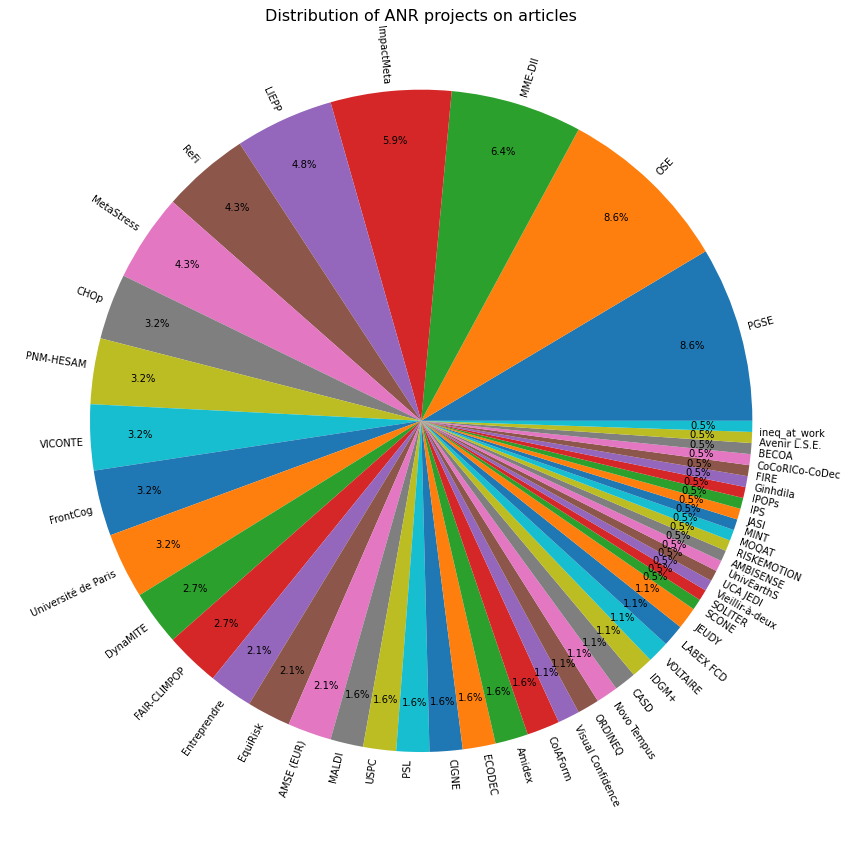

[2023-03-26 11:00:07][INFO ][funding_stats#50] Saving figure to "./exports/fundings_anr_global_occurence.png"
[2023-03-26 11:00:07][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_count.csv (params: {'index': False}) (number of rows: 760)
[2023-03-26 11:00:07][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_repartition.csv (params: {'index': False}) (number of rows: 5)


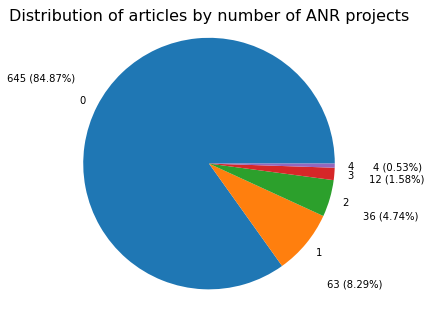

[2023-03-26 11:00:07][INFO ][funding_stats#100] Saving figure to "./exports/fundings_anr_global_repartition.png"
[2023-03-26 11:00:07][INFO ][funding_stats#104] End processing funding for filemane "anr_global" outputs


In [38]:
funding_stats(
    dataframe=df_art,
    columns=['anrProjectAcronym_s', 'anrProjectReference_s'],
    filename='anr_global',
    occurence_params=dict(title='Distribution of ANR projects on articles'),
    repartition_params=dict(title='Distribution of articles by number of ANR projects', figsize=(6,6), pctdistance=1.5),
)

### European

[2023-03-26 11:00:07][INFO ][funding_stats#9] Start processing funding for output filename "european_global" based on columns: ['europeanProjectAcronym_s', 'europeanProjectReference_s']
[2023-03-26 11:00:07][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_uri.csv (params: {'index': False}) (number of rows: 45)
[2023-03-26 11:00:07][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_occurence.csv (params: {'index': False}) (number of rows: 28)


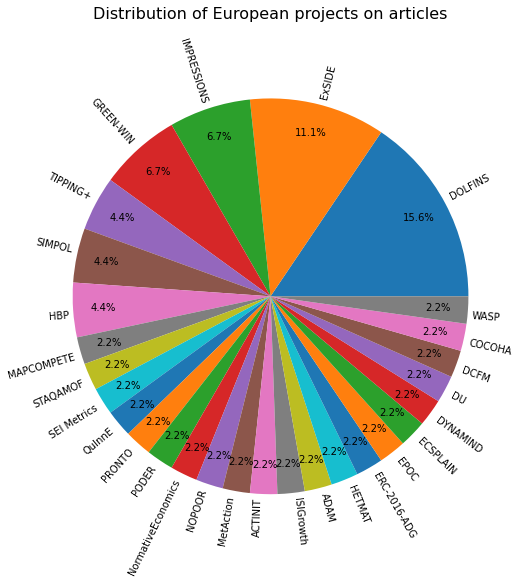

[2023-03-26 11:00:07][INFO ][funding_stats#50] Saving figure to "./exports/fundings_european_global_occurence.png"
[2023-03-26 11:00:07][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_count.csv (params: {'index': False}) (number of rows: 760)
[2023-03-26 11:00:07][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_repartition.csv (params: {'index': False}) (number of rows: 5)


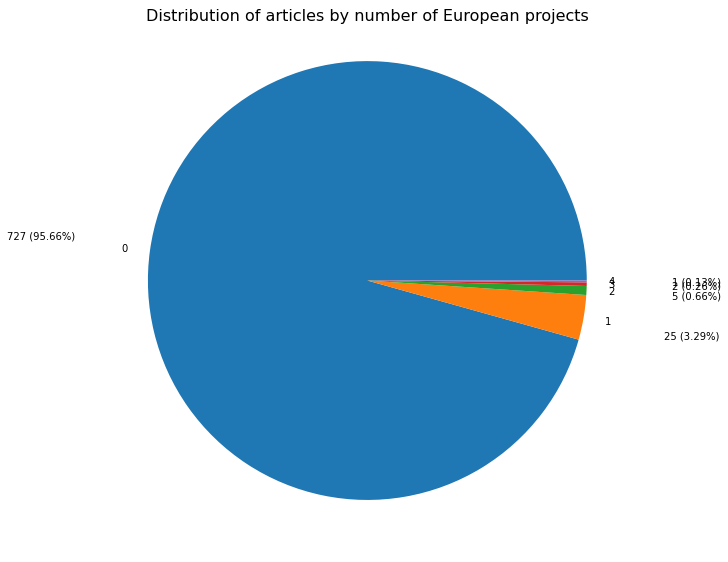

[2023-03-26 11:00:07][INFO ][funding_stats#100] Saving figure to "./exports/fundings_european_global_repartition.png"
[2023-03-26 11:00:07][INFO ][funding_stats#104] End processing funding for filemane "european_global" outputs


In [39]:
funding_stats(
    dataframe = df_art,
    columns = ['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename = 'european_global',
    occurence_params = dict(
        title = 'Distribution of European projects on articles',
        figsize=(8, 8)
    ),
    occurence_title_params = dict(
        pad = 30
    ),
    repartition_params = dict(
        title = 'Distribution of articles by number of European projects',
        figsize = (10, 10),
        pctdistance = 1.5
    ),
)

[2023-03-26 11:00:07][INFO ][funding_stats#9] Start processing funding for output filename "european_global_top" based on columns: ['europeanProjectAcronym_s', 'europeanProjectReference_s']
[2023-03-26 11:00:07][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_top_uri.csv (params: {'index': False}) (number of rows: 45)
[2023-03-26 11:00:07][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_top_occurence.csv (params: {'index': False}) (number of rows: 28)


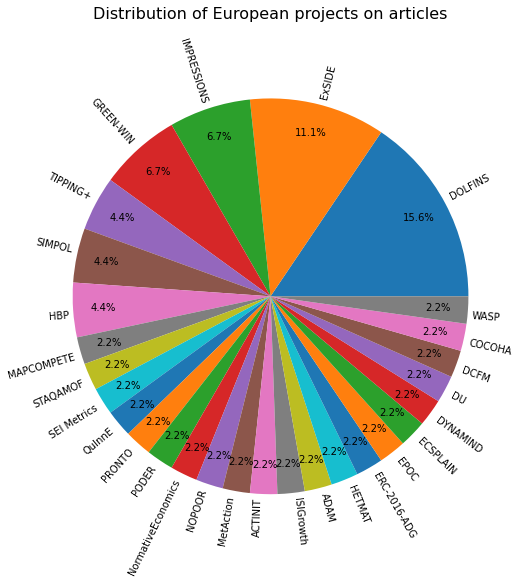

[2023-03-26 11:00:08][INFO ][funding_stats#50] Saving figure to "./exports/fundings_european_global_top_occurence.png"
[2023-03-26 11:00:08][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_top_count.csv (params: {'index': False}) (number of rows: 760)
[2023-03-26 11:00:08][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_top_repartition.csv (params: {'index': False}) (number of rows: 5)
[2023-03-26 11:00:08][INFO ][group_min_values#152] Create a new dataframe for other values (others=(col['number_of_count'] < 6]) => 3 rows aggreated
[2023-03-26 11:00:08][INFO ][group_min_values#167] New dataframe size: 3 (Original dataframe size: 5)


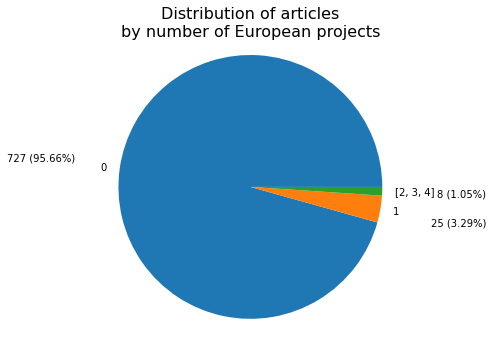

[2023-03-26 11:00:08][INFO ][funding_stats#100] Saving figure to "./exports/fundings_european_global_top_repartition.png"
[2023-03-26 11:00:08][INFO ][funding_stats#104] End processing funding for filemane "european_global_top" outputs


In [40]:
funding_stats(
    dataframe = df_art,
    columns = ['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename = 'european_global_top',
    occurence_params = dict(
        title = 'Distribution of European projects on articles',
        figsize = (8, 8)
    ),
    occurence_title_params = dict(
        pad = 30
    ),
    repartition_params = dict(
        title = 'Distribution of articles\nby number of European projects',
        figsize = (7, 7),
        pctdistance = 1.6
    ),
    repartition_group_min = 6,
)

### Others

In [41]:
other_fundings = df_art.explode(['funding_s'])
other_fundings = other_fundings[['uri_s', 'funding_s']]
other_fundings.dropna().to_csv(path_or_buf='./exports/fundings_other_uri.csv', index=False)
other_fundings = other_fundings[['funding_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
other_fundings.to_csv(path_or_buf='./exports/fundings_other_stats.csv', index=False)
other_fundings.head(n=5)

,funding_s,count
0,NaN,626
1,This work was achieved through the Laboratory ...,2
2,This research was supported by the Agence Nati...,1
3,This research has received funding from the Eu...,1
4,This research was partially funded by ANR prog...,1


## Collaborations

### Structure/institution: Country (instStructCountry_s)

An article, may have several `instStructCountry_s`.

We explode the dataset based on the field `instStructCountry_s` to have only one country by row.

In [42]:
collaboration_struct_countries = df_art[['uri_s', 'instStructCountry_s']]
collaboration_struct_countries = collaboration_struct_countries.explode(['instStructCountry_s'])
collaboration_struct_countries

,uri_s,instStructCountry_s
0,https://hal.science/hal-03534771,fr
0,https://hal.science/hal-03534771,fr
1,https://hal.science/hal-03233310,fr
2,https://hal.science/hal-03205154,fr
2,https://hal.science/hal-03205154,it
...,...,...
757,https://hal.science/hal-02865203,fr
758,https://hal.science/hal-02862823,fr
758,https://hal.science/hal-02862823,fr
759,https://hal.science/hal-02974389,cn


In [43]:
collaboration_struct_country_values = collaboration_struct_countries[['instStructCountry_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_country_values.to_csv(f'./exports/colloborations_inst_struct_country.csv', index=False)
collaboration_struct_country_values.head(n=5)

,instStructCountry_s,count
0,fr,3244
1,us,87
2,gb,60
3,it,48
4,de,44


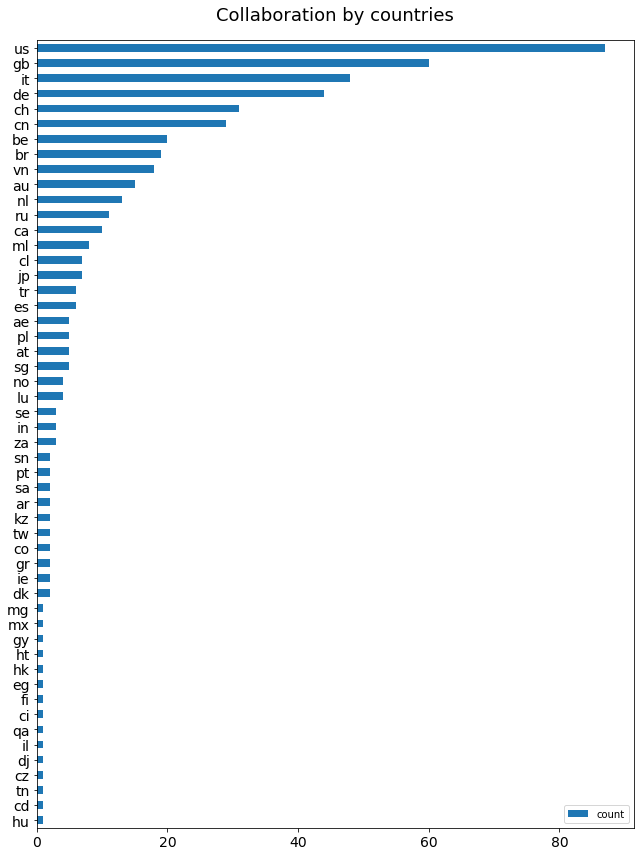

In [44]:
p = collaboration_struct_country_values[(collaboration_struct_country_values.instStructCountry_s != 'fr')].sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Collaboration by countries',
    x='instStructCountry_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(9, 12),
    fontsize=14,
    rot=0,
)
p.set_title('Collaboration by countries',pad=20, fontdict={'fontsize':18})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_country_count.png', bbox_inches='tight')

### Structure/institution: Name (instStructName_s)

An article, may have several `instStructName_s`.

We explode the dataset based on the field `instStructName_s` to have only one structure by row.

In [45]:
collaboration_struct_names = df_art[['uri_s', 'instStructName_s']]
collaboration_struct_names = collaboration_struct_names.explode(['instStructName_s'])
collaboration_struct_names

,uri_s,instStructName_s
0,https://hal.science/hal-03534771,Université Paris 1 Panthéon-Sorbonne
0,https://hal.science/hal-03534771,Université Paris 1 Panthéon-Sorbonne
1,https://hal.science/hal-03233310,Université Paris 1 Panthéon-Sorbonne
1,https://hal.science/hal-03233310,Université Tsinghua de Beijing
1,https://hal.science/hal-03233310,Université Tianjin de Nankai
...,...,...
758,https://hal.science/hal-02862823,École Nationale de la Statistique et de l'Admi...
758,https://hal.science/hal-02862823,Université Paris 1 Panthéon-Sorbonne
758,https://hal.science/hal-02862823,Institut europlace de finance
759,https://hal.science/hal-02974389,Tsinghua University [Beijing]


In [46]:
collaboration_struct_name_aggregation_min = 6
collaboration_struct_name_values = collaboration_struct_names[['instStructName_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name.csv', index=False)
collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != 'Centre National de la Recherche Scientifique')]
collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != 'Université Paris 1 Panthéon-Sorbonne')]
# Retrieve small collaboration to create a new row 'others'
collaboration_struct_name_others = collaboration_struct_name_values[(collaboration_struct_name_values['count'] <= collaboration_struct_name_aggregation_min)]
collaboration_struct_name_others_size = collaboration_struct_name_others['instStructName_s'].size
collaboration_struct_name_others = pd.DataFrame(
    dict(
        instStructName_s=f'Others ({collaboration_struct_name_others_size})',
        count=collaboration_struct_name_others['count'].sum()
    ),
    index=[0]
)
# Cleanup base df for collaboration
collaboration_struct_name_top = collaboration_struct_name_values[(collaboration_struct_name_values['count'] > collaboration_struct_name_aggregation_min)]
collaboration_struct_name_values = pd.concat([collaboration_struct_name_top, collaboration_struct_name_others], ignore_index=True)
collaboration_struct_name_values = collaboration_struct_name_values.sort_values(by=['count'], ascending=False)
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name_filtered_{collaboration_struct_name_aggregation_min}.csv', index=False)
collaboration_struct_name_values.head(n=5)

,instStructName_s,count
54,Others (472),761
0,École des hautes études en sciences sociales,316
1,École normale supérieure - Paris,306
2,École des Ponts ParisTech,281
3,Institut National de Recherche pour l’Agricult...,279


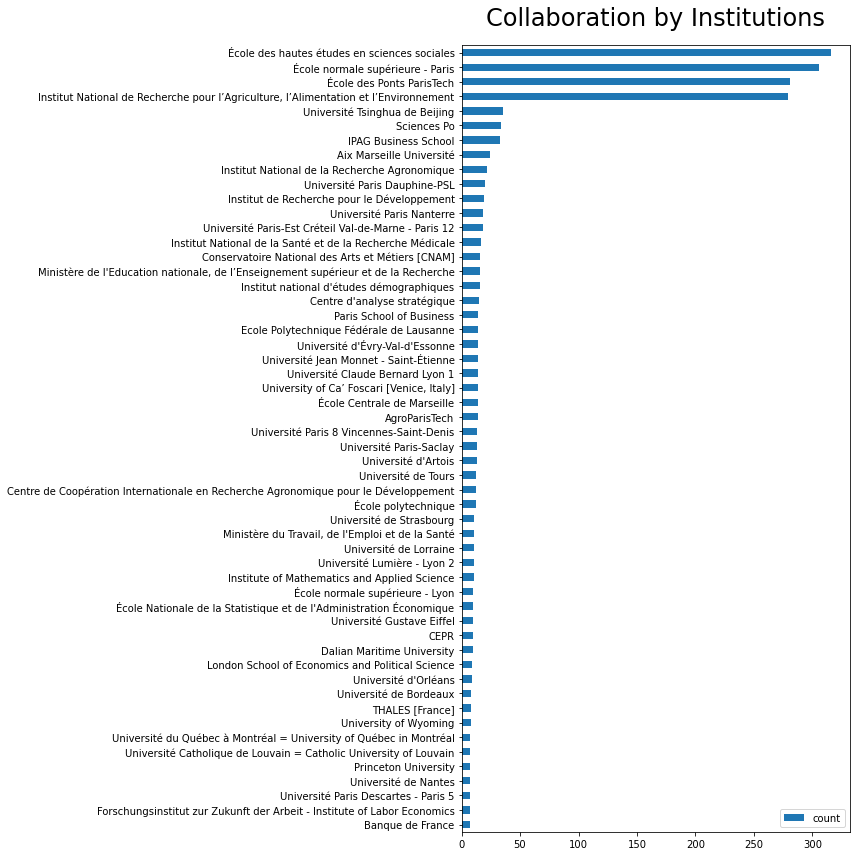

In [47]:
p = collaboration_struct_name_top.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institutions',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 12)
)
p.set_title('Collaboration by Institutions', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count_without_others.png', bbox_inches='tight')

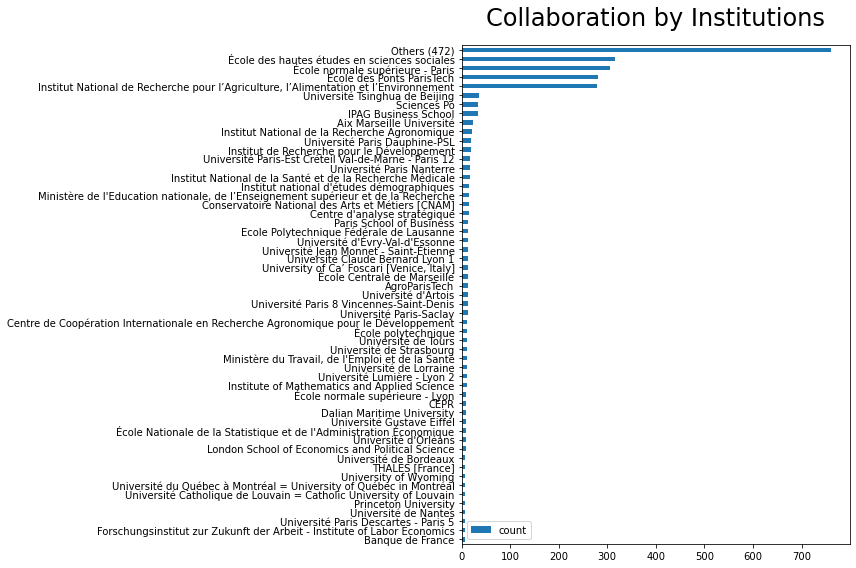

In [48]:
p = collaboration_struct_name_values.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institutions',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 8)
)
p.set_title('Collaboration by Institutions', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count.png', bbox_inches='tight')

## Full text

Also named attached files ...

An article may have multiple attached files. We will count the number of attached files here by document.

In [49]:
def full_text(dataframe,
              title: str,
              filename: Optional[str] = None,
              params: Dict[str, Any] = dict()):
    
    filename = (filename or '').strip()
    prefix_filename = f'full_text_{filename}' if len(filename) > 0 else 'full_text'
    
    attached_files = dataframe[['uri_s', 'files_s']].copy()
    attached_files['attached_files_count'] = attached_files['files_s'].apply(lambda x: len(x) if pd.notnull(x) else 0)
    DfOps(attached_files[['uri_s', 'attached_files_count']]).csv(filename=f'{prefix_filename}.csv', index=False)
     
    attached_files_number = attached_files['attached_files_count'].value_counts().sort_index()
    DfOps(attached_files_number).csv(filename=f'{prefix_filename}_distribution.csv', index=False)
    
    default_params = dict(   
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        #title=title,
        ylabel='',
        labels=attached_files_number.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * attached_files_number.sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    attached_files_number_png_target_file = f'./exports/{prefix_filename}_distribution.png'
    axs = attached_files_number.plot(**{**default_params, **params})
    plt.tight_layout()
    axs[0].set_ylabel('')
    axs[0].set_title(
        label = title,
        y = 1.0,
        pad = 6,
        fontdict = {'fontsize': 16},
    )
    plt.figure(1).savefig(attached_files_number_png_target_file, bbox_inches='tight')
    plt.show()
    LOGGER.info('Saving figure to : "%s"', attached_files_number_png_target_file)
    return attached_files 

[2023-03-26 11:00:11][INFO ][csv#35] Export to CSV file: ./exports/full_text.csv (params: {'index': False}) (number of rows: 760)
[2023-03-26 11:00:11][INFO ][csv#35] Export to CSV file: ./exports/full_text_distribution.csv (params: {'index': False}) (number of rows: 2)


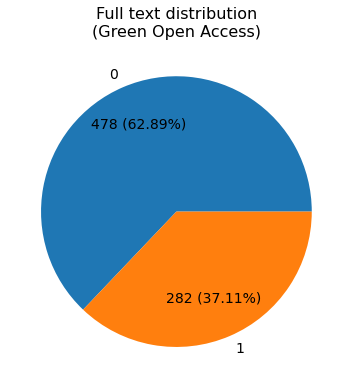

[2023-03-26 11:00:11][INFO ][full_text#41] Saving figure to : "./exports/full_text_distribution.png"


,uri_s,files_s,attached_files_count
0,https://hal.science/hal-03534771,[https://hal.science/hal-03534771/file/WILL%20...,1
1,https://hal.science/hal-03233310,NaN,0
2,https://hal.science/hal-03205154,[https://hal.science/hal-03205154/file/S154461...,1
3,https://hal-cnrs.archives-ouvertes.fr/hal-0390...,NaN,0
4,https://hal.science/hal-03912939,NaN,0
...,...,...,...
755,https://hal.science/hal-03767916,[https://hal.science/hal-03767916/file/WD_revi...,1
756,https://hal.science/hal-02862765,NaN,0
757,https://hal.science/hal-02865203,NaN,0
758,https://hal.science/hal-02862823,NaN,0


In [50]:
full_text(
    dataframe=df_art,
    title='Full text distribution\n(Green Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

## Open Access

In [51]:
def open_access(dataframe,
                title: str,
                filename: str = None,
                params: Dict[str, Any] = dict()):
    
    filename = (filename or '').strip()
    prefix_filename = f'open_access_{filename}' if len(filename) > 0 else 'open_access'
    
    open_access_number_series = dataframe['openAccess_bool'].value_counts().reindex([True, False])
    open_access_number = open_access_number_series.to_frame(name='count').reset_index()
    DfOps(open_access_number).csv(filename=f'{prefix_filename}_distribution.csv', index=False)
    
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        #title=title,
        ylabel='',
        labels=open_access_number_series.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * open_access_number['count'].sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    open_access_number_png_target_file = f'./exports/{prefix_filename}_distribution.png'
    axs = open_access_number_series.plot(**{**default_params, **params})
    plt.tight_layout()
    axs[0].set_ylabel('')
    axs[0].set_title(
        label = title,
        y = 1.0,
        pad = 6,
        fontdict = {'fontsize': 16},
    )
    plt.figure(1).savefig(open_access_number_png_target_file, bbox_inches='tight')
    plt.show()
    LOGGER.info('Saving figure to: "%s"', open_access_number_png_target_file)
    
    return open_access_number

[2023-03-26 11:00:11][INFO ][csv#35] Export to CSV file: ./exports/open_access_distribution.csv (params: {'index': False}) (number of rows: 2)


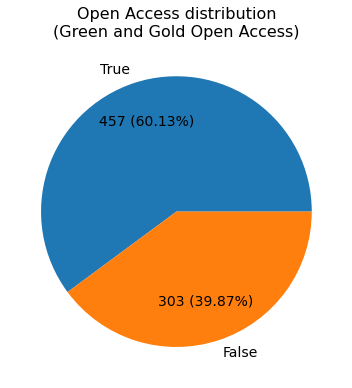

[2023-03-26 11:00:12][INFO ][open_access#38] Saving figure to: "./exports/open_access_distribution.png"


,index,count
0,True,457
1,False,303


In [52]:
open_access(
    dataframe=df_art,
    title='Open Access distribution\n(Green and Gold Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

## Ranking



In [53]:
def create_ranking_journals_df(dataframe: pd.core.frame.DataFrame,
                               filename_prefix: Optional[str] = None,
                               excludes: Optional[List[str]] = None):
    excludes = excludes or []
    includes = [i for i in ['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES'] if i not in excludes]
    LOGGER.info('Create ranking dataframe including: %s (excludes=%s)', includes, excludes)
    
    
    ranking_journals = dataframe[['uri_s', 'journalTitle_s', 'journalIssn_s']].copy()
    ranking_journals['ISSN'] = ranking_journals['journalIssn_s']
    # Econlit
    if 'ECONLIT' in includes:
        ranking_journals = ranking_journals.merge(econlit_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['ECONLIT'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title'])
    
    # MathSciNet
    if 'MATHSCINET' in includes:
        ranking_journals = ranking_journals.merge(mathscinet_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['MATHSCINET'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title'])
    
    # Scimago
    if 'SCIMAGO' in includes:
        ranking_journals = ranking_journals.merge(scimagojr_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['SCIMAGO'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title']).rename(columns={'CATEGORIES': 'SCIMAGO_CATEGORIES'})
    
    # HCERES
    if 'HCERES' in includes:
        ranking_journals = ranking_journals.merge(hceres_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals = ranking_journals.drop(columns=['Title'])
        ranking_journals['HCERES'] = ranking_journals['HCERES_2021'].notnull()
        ranking_journals = ranking_journals.rename(columns={'HCERES_2021': 'HCERES_RANK', 'CoNRS_2020': 'HCERES_CONRS_RANK', 'FNEGE_2019': 'HCERES_FNEGE_RANK'})
    
    # HCERES + Scimago + MathSciNet + Econlit (if includes)
    ranking_journals['NUMBER_OF_REFERENTIALS'] = ranking_journals[includes].apply(lambda x: x.sum(), axis=1, raw=True)
    
    # Cleanup data
    ranking_journals = ranking_journals.drop(columns=['ISSN'])
    if filename_prefix:
        DfOps(ranking_journals).csv(filename=f'{filename_prefix}.csv', index=False)
    
    return ranking_journals

In [54]:
def journals_ranking_plot(dataframe: pd.core.frame.DataFrame,
                          titles: Dict[str, str] = dict(),
                          filename_prefix: str = 'rankings'):
    titles = titles or {}
    possible_columns = ['MATHSCINET', 'SCIMAGO', 'ECONLIT', 'HCERES']
    columns = [i for i in possible_columns if i in dataframe]
    
    if not columns:
        LOGGER.warn('Cannot plot journals ranking as there is no columns in: %s', possible_columns)
        return
    
    target_file_filtered = f'./exports/{filename_prefix}_filtered.csv'
    DfOps(dataframe[['uri_s'] + columns]).csv(filename=f'{filename_prefix}_filtered.csv', index=False)
    
    ranking_aggregation_transposed = dataframe[columns].apply(pd.Series.value_counts).transpose().fillna(0)
    DfOps(ranking_aggregation_transposed).csv(filename=f'{filename_prefix}_count.csv', index=False)

    true_values = ranking_aggregation_transposed[True].tolist()
    true_labels = round(100 * ranking_aggregation_transposed[True] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    true_labels = ranking_aggregation_transposed[True].combine(true_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    false_values = ranking_aggregation_transposed[False].tolist()
    false_labels = round(100 * ranking_aggregation_transposed[False] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    false_labels = ranking_aggregation_transposed[False].combine(false_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    ind = np.arange(len(true_values)) 
    width = 0.60

    fig, ax = plt.subplots(figsize=(12,6))

    true_plot = ax.barh(columns, true_values, width, label='True', linewidth=0 )
    false_plot = ax.barh(columns, false_values, width, left=true_values, label='False', linewidth=0)

    title = 'Articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default: %s)', title, title)
    title = titles.get('Articles ranking', 'Articles ranking')
    ax.set_title(title, pad=10, fontsize=18)
    ax.set_xlabel('Articles', fontsize=13)
    ax.bar_label(true_plot, label_type='center', fontsize=13, labels=true_labels)
    ax.bar_label(false_plot, label_type='center', fontsize=13, labels=false_labels)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=13)
    fig.tight_layout()
    target_file_general = f'./exports/{filename_prefix}_general.png'
    fig.savefig(target_file_general, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file_general)
    plt.show()

In [55]:
def hceres_ranking_plot(dataframe: pd.core.frame.DataFrame,
                        titles: Dict[str, str] = dict(),
                        filename_prefix: str = 'rankings',
                        params:Dict[str, Any] = dict()):
    if 'HCERES_RANK' not in dataframe:
        LOGGER.warn('Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame')
        return
    
    titles = titles or {}
    title = 'HCERES articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title) 
    title = titles.get(title, title)
    
    LOGGER.info('Create ranking plot "%s" for HCERES (params=%s)', title, params)
    hceres_rankings = dataframe['HCERES_RANK'].dropna().value_counts().sort_index()
    DfOps(hceres_rankings.to_frame(name='count_hceres_ranks')).csv(filename=f'{filename_prefix}_hceres.csv', index=False)
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=hceres_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * hceres_rankings.sum() / 100)),
        pctdistance=0.6,
        fontsize=14,
    )
    hceres_rankings.plot(**{**default_params, **params})
   
    plt.figure(1).axes[0].set_title(title, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    target_file_png = f'./exports/{filename_prefix}_hceres.png'
    plt.figure(1).savefig(target_file_png, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file_png)
    plt.show()

In [56]:
def create_scimajo_df(dataframe: pd.core.frame.DataFrame,
                      filename_prefix: str = 'rankings',
                      suffix: int = 0,
                      quantile: float = 0.0) -> pd.core.frame.DataFrame:
    
    if 'SCIMAGO_CATEGORIES' not in dataframe:
        LOGGER.warn('Cannot create scimajo dataframe as "SCIMAGO_CATEGORIES" column doesn\'t exist')
        return pd.DataFrame()
    
    scimagojr_categories = dataframe[['uri_s', 'journalTitle_s', 'SCIMAGO_CATEGORIES']].copy().dropna()
    scimagojr_categories['CATEGORY'] = scimagojr_categories['SCIMAGO_CATEGORIES'].str.split(';')
    scimagojr_categories = scimagojr_categories.explode('CATEGORY')
    scimagojr_categories['CATEGORY'] = scimagojr_categories['CATEGORY'].str.strip()
    scimagojr_categories['SCIMAGO_JOURNAL_RANKING'] = scimagojr_categories['CATEGORY'].str.extract('^.*\((?P<sjr>Q[1-4])\)\s*$')
    scimagojr_categories['CATEGORY_WITHOUT_SJR'] = scimagojr_categories['CATEGORY'].str.extract('^(?P<cat>.*)\s+\(Q[1-4]\)\s*$')
    scimagojr_categories = scimagojr_categories.reset_index(drop=True)
    target_file = f'./exports/{filename_prefix}_scimago.csv'
    scimagojr_categories.to_csv(target_file, index=False)
    LOGGER.info('Saved CSV at "%s"', target_file)
    
    # Add a category others when we have to small values
    if quantile > 0:
        LOGGER.info('Rework dataframe to group the less used categories (quantile=%f)', quantile)
        scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts()
        bottom_value = scimagojr_category_names.quantile(q=quantile)
        less_freq_scimagojr_category_names = scimagojr_category_names[scimagojr_category_names <= bottom_value]
        scimagojr_categories.loc[scimagojr_categories['CATEGORY_WITHOUT_SJR'].isin(less_freq_scimagojr_category_names.index.tolist())] = "Others"
    
    target_file_filtered = f'./exports/{filename_prefix}_scimago_filtered_{suffix}.csv'
    scimagojr_categories.to_csv(target_file_filtered, index=False)
    LOGGER.info('Saved CSV at "%s', target_file_filtered)
    
    # Create a new column with category with percent (for the occurence of this category)
    scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts().to_frame().reset_index()
    scimagojr_category_names = scimagojr_category_names.rename(columns={'index': 'CATEGORY_WITHOUT_SJR', 'CATEGORY_WITHOUT_SJR': 'CATEGORY_WITHOUT_SJR_COUNT'})
    scimagojr_category_names['CATEGORY_WITHOUT_JSR_PERCENT'] = scimagojr_category_names.apply(
        lambda row: '{n} - {v} ({p}%)'.format(
            n = row['CATEGORY_WITHOUT_SJR'],
            v = row['CATEGORY_WITHOUT_SJR_COUNT'],
            p = round(100 * row['CATEGORY_WITHOUT_SJR_COUNT'] / scimagojr_category_names['CATEGORY_WITHOUT_SJR_COUNT'].sum(), 1)
        ),
        axis='columns'
    )

    # Merge with initial dataframe
    scimagojr_categories = scimagojr_categories.merge(scimagojr_category_names, how='inner', on=['CATEGORY_WITHOUT_SJR'])
    
    return scimagojr_categories

In [57]:
def scimago_ranking_plot(dataframe: pd.core.frame.DataFrame,
                         titles: Dict[str, str] = dict(),
                         filename_prefix: str = 'rankings',
                         suffix: int = 0,
                         category_params:Dict[str, Any] = dict()):
    if 'CATEGORY_WITHOUT_JSR_PERCENT' not in dataframe:
        LOGGER.warn('Skip plotting Scimago as "CATEGORY_WITHOUT_JSR_PERCENT" is not a column of the DataFrame')
    
    titles = titles or {}
    
    # Fig 1 : Category
    scimago_category_names = dataframe['CATEGORY_WITHOUT_JSR_PERCENT'].value_counts()
    default_category_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimago_category_names.index.tolist(),
        figsize=(18, 12),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimago_category_names.sum() / 100)),
        pctdistance=0.9,
        labeldistance=None,
        legend=True
    )
    
    title_categories = 'Scimago JCR: categories'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title_categories, title_categories)
    title_categories = titles.get(title_categories, title_categories)
    target_file_categories = f'./exports/{filename_prefix}_scimago_categories_{suffix}.png'
    
    scimago_category_names.plot(**{**default_category_params, **category_params})
    plt.legend(loc='best', bbox_to_anchor=(0.1, 0.9))
    plt.figure(1).axes[0].set_title(title_categories, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    
    plt.figure(1).savefig(target_file_categories, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file_categories)
    plt.show()
    
    # Fig 2 : SJR Repartition
    scimajo_journal_rankings = dataframe['SCIMAGO_JOURNAL_RANKING'].value_counts()
    scimajo_journal_rankings.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimajo_journal_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimajo_journal_rankings.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    
    title_quartiles = 'Scimago JCR: quartiles'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title_quartiles, title_quartiles)
    title_quartiles = titles.get(title_quartiles, title_quartiles)
    target_file_quartiles = f'./exports/{filename_prefix}_scimago_sjr_q_score_{suffix}.png'
    
    plt.figure(1).axes[0].set_title(title_quartiles, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(target_file_quartiles, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file_quartiles)
    plt.show()

In [58]:
def cross_referentials_plot(dataframe: pd.core.frame.DataFrame,
                            titles: Dict[str, str] = dict(),
                            filename_prefix: str = 'rankings'):
    
    titles = titles or {}
    title = 'Distribution of articles'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title)
    title = titles.get(title, title)
    target_file = f'./exports/{filename_prefix}_distribution_of_articles_in_journal_classification_referentials.png'
    
    cross_ref_s = dataframe['NUMBER_OF_REFERENTIALS'].value_counts().sort_index()
    cross_ref_s.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=cross_ref_s.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * cross_ref_s.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    plt.figure(1).axes[0].set_title(title, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(target_file, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file)
    plt.show()

In [59]:
def scimago_hceres_matrix(dataframe: pd.core.frame.DataFrame,
                          filename_prefix: str = 'rankings') -> pd.core.frame.DataFrame:
    if 'HCERES_RANK' not in dataframe or 'SJR_BEST_QUARTILE' not in dataframe:
        LOGGER.warn('Cannot create a matrix for HCERES*Scimago Best Quartile as current dataframe doesn\'t have the columns')
        return pd.DataFrame()

    target_base_file = f'./exports/{filename_prefix}_hceres_scimago_matrix'
    LOGGER.info('Create Scimago / HCERES matrix')
    ranking_scimago_hceres_df = dataframe[['HCERES_RANK', 'SJR_BEST_QUARTILE']].fillna('NON REFERENCE')
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.value_counts(dropna=False)
    
    ranking_scimago_hceres_df.to_excel(f'{target_base_file}.xlsx')
    LOGGER.info('Saved Excel at "%s.xlsx"', target_base_file)
    
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.unstack(fill_value=0)
    ranking_scimago_hceres_df.to_excel(f'{target_base_file}_2.xlsx')
    LOGGER.info('Saved Excel at "%s_2.xlsx"', target_base_file)
    return ranking_scimago_hceres_df

In [60]:
def rankings(dataframe: pd.core.frame.DataFrame,
             titles: Dict[str, str] = dict(),
             excludes: List[str] = [],
             filename_prefix: str = 'rankings',
             hceres_category_params: Dict[str, Any] = dict()):
    LOGGER.info('Process ranking (filename_prefix=%s, titles=%s)', filename_prefix, titles)
    rankings_journals = create_ranking_journals_df(
        dataframe = dataframe,
        excludes = excludes,
        filename_prefix = filename_prefix
    )
    journals_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix
    )
    hceres_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix,
        params = hceres_category_params
    )
    cross_referentials_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix
    )
    return rankings_journals

In [61]:
def scimago_rankings(dataframe: pd.core.frame.DataFrame,
                     titles: Dict[str, str] = dict(),
                     filename_prefix: str = 'rankings',
                     suffix: int = 0,
                     quantile: float = 0.0,
                     category_params: Dict[str, Any] = dict()):
    # The input dataframe should be a return of create_ranking_journals_df or rankings
    LOGGER.info('Process scimago rankings (filename_prefix=%s, titles=%s)', filename_prefix, titles) 
    scimajo_df = create_scimajo_df(
        dataframe=dataframe,
        filename_prefix=filename_prefix,
        suffix=suffix,
        quantile=quantile
    )
    scimago_ranking_plot(
        dataframe=scimajo_df,
        titles=titles,
        filename_prefix=filename_prefix,
        suffix=suffix,
        category_params=category_params
    )

### Using all ranking systems

[2023-03-26 11:00:12][INFO ][rankings#6] Process ranking (filename_prefix=rankings, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-03-26 11:00:12][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES'] (excludes=[])
[2023-03-26 11:00:12][INFO ][csv#35] Export to CSV file: ./exports/rankings.csv (params: {'index': False}) (number of rows: 760)
[2023-03-26 11:00:12][INFO ][csv#35] Export to CSV file: ./exports/rankings_filtered.csv (params: {'index': False}) (number of rows: 760)
[2023-03-26 11:00:12][INFO ][csv#35] Export to CSV file: ./exports/rankings_count.csv (params: {'index': False}) (number of rows: 4)
[2023-03-26 11:00:12][INFO ][journals_ranking_plot#45] Saved figur

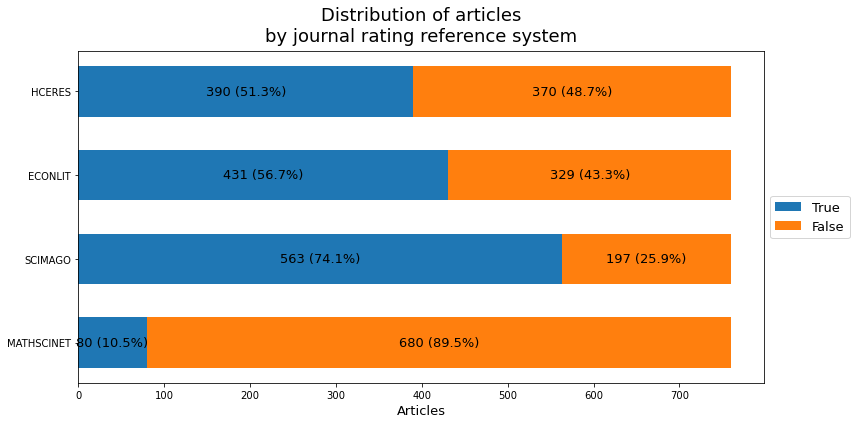

[2023-03-26 11:00:12][INFO ][hceres_ranking_plot#14] Create ranking plot "Distribution of articles
for the HCERES Vague C 2021 rating reference system" for HCERES (params={})
[2023-03-26 11:00:12][INFO ][csv#35] Export to CSV file: ./exports/rankings_hceres.csv (params: {'index': False}) (number of rows: 3)
[2023-03-26 11:00:12][INFO ][hceres_ranking_plot#35] Saved figure at "./exports/rankings_hceres.png"


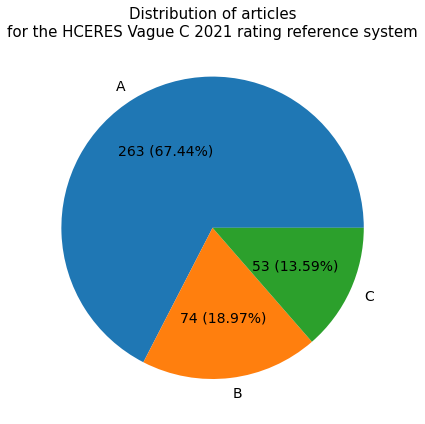

[2023-03-26 11:00:12][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_distribution_of_articles_in_journal_classification_referentials.png"


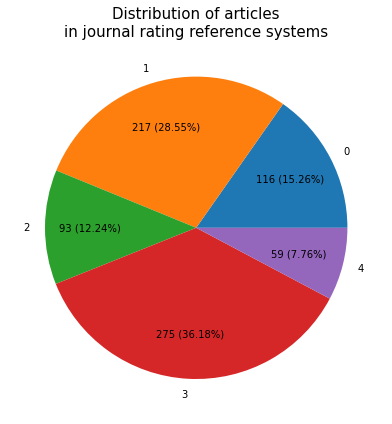

[2023-03-26 11:00:12][INFO ][scimago_hceres_matrix#8] Create Scimago / HCERES matrix
[2023-03-26 11:00:12][INFO ][scimago_hceres_matrix#13] Saved Excel at "./exports/rankings_hceres_scimago_matrix.xlsx"
[2023-03-26 11:00:12][INFO ][scimago_hceres_matrix#17] Saved Excel at "./exports/rankings_hceres_scimago_matrix_2.xlsx"
[2023-03-26 11:00:12][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-03-26 11:00:12][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_scimago.csv"
[2023-03-26 11:00:12][INFO ][create_scimajo_df#23] Rework dataframe to group the less used categories (quantile=0.600000)
[2023-03-26 11:00:12][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_scimago_filtered_0.csv
[2023-03-26 11:00

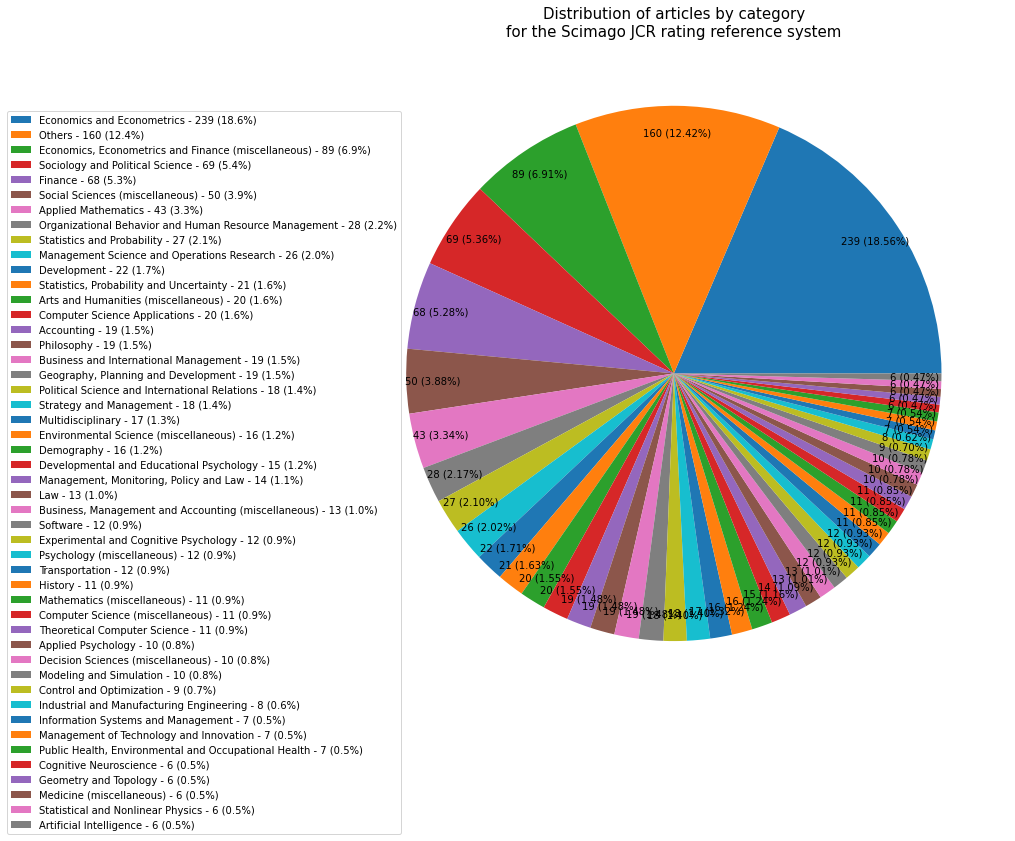

[2023-03-26 11:00:14][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_scimago_sjr_q_score_0.png"


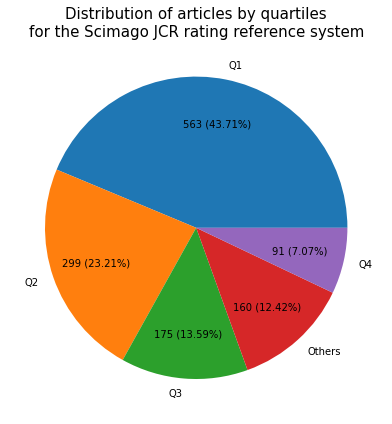

,uri_s,journalTitle_s,journalIssn_s,URL,ECONLIT,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,HCERES_CONRS_RANK,HCERES_FNEGE_RANK,HCERES_RANK,HCERES,NUMBER_OF_REFERENTIALS
0,https://hal.science/hal-03534771,Zagadnienia Ekonomiki Rolnej / Problems of Agr...,0044-1600,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,0
1,https://hal.science/hal-03233310,Recherches Internationales,0294-3069,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,0
2,https://hal.science/hal-03205154,Finance Research Letters,1544-6123,NaN,False,False,Finance (Q1),Q1,True,3,3,B,True,2
3,https://hal-cnrs.archives-ouvertes.fr/hal-0390...,Recherches Internationales,0294-3069,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,0
4,https://hal.science/hal-03912939,Recherches Internationales,0294-3069,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,https://hal.science/hal-03767916,World Development,0305-750X,http://www.sciencedirect.com/science/journal/0...,True,False,Development (Q1); Economics and Econometrics (...,Q1,True,1,NaN,A,True,3
756,https://hal.science/hal-02862765,The Journal of Risk,1465-1211,http://www.risk.net/type/journal/source/journa...,True,False,Finance (Q4); Strategy and Management (Q4),Q4,True,NaN,NaN,NaN,False,2
757,https://hal.science/hal-02865203,Demography,0070-3370,https://read.dukeupress.edu/demography/issue,True,False,Demography (Q1),Q1,True,1,NaN,A,True,3
758,https://hal.science/hal-02862823,Market microstructure and liquidity,2382-6266,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,0


In [62]:
ranking_df = rankings(
    dataframe=df_art,
    titles={
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_hceres_matrix(dataframe=ranking_df)
scimago_rankings(
    dataframe=ranking_df,
    quantile=0.6,
    titles={
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    }
)
ranking_df

### Without HCERES

[2023-03-26 11:00:14][INFO ][rankings#6] Process ranking (filename_prefix=rankings, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-03-26 11:00:14][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['ECONLIT', 'MATHSCINET', 'SCIMAGO'] (excludes=['HCERES'])
[2023-03-26 11:00:14][INFO ][csv#35] Export to CSV file: ./exports/rankings.csv (params: {'index': False}) (number of rows: 760)
[2023-03-26 11:00:14][INFO ][csv#35] Export to CSV file: ./exports/rankings_filtered.csv (params: {'index': False}) (number of rows: 760)
[2023-03-26 11:00:14][INFO ][csv#35] Export to CSV file: ./exports/rankings_count.csv (params: {'index': False}) (number of rows: 3)
[2023-03-26 11:00:14][INFO ][journals_ranking_plot#45] Saved figure 

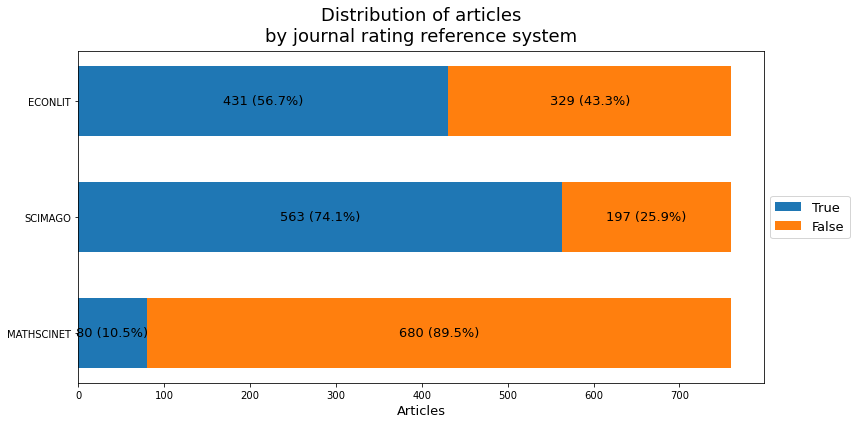

/tmp/ipykernel_282/2134209590.py:6: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn('Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame')
[2023-03-26 11:00:14][WARNING][hceres_ranking_plot#6] Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame
[2023-03-26 11:00:14][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_distribution_of_articles_in_journal_classification_referentials.png"


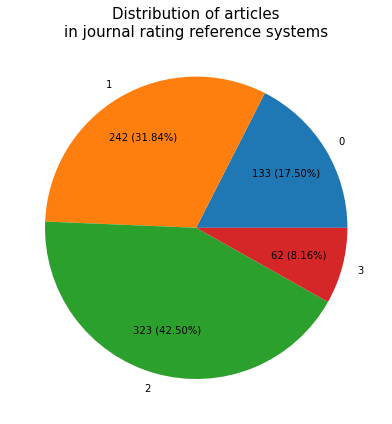

/tmp/ipykernel_282/231509950.py:4: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn('Cannot create a matrix for HCERES*Scimago Best Quartile as current dataframe doesn\'t have the columns')
[2023-03-26 11:00:15][WARNING][scimago_hceres_matrix#4] Cannot create a matrix for HCERES*Scimago Best Quartile as current dataframe doesn't have the columns
[2023-03-26 11:00:15][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-03-26 11:00:15][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_scimago.csv"
[2023-03-26 11:00:15][INFO ][create_scimajo_df#23] Rework dataframe to group the less used categories (quantile=0.600000)
[2023-03-26 11:00:15][INFO ][create_scimajo_df#31] Saved CS

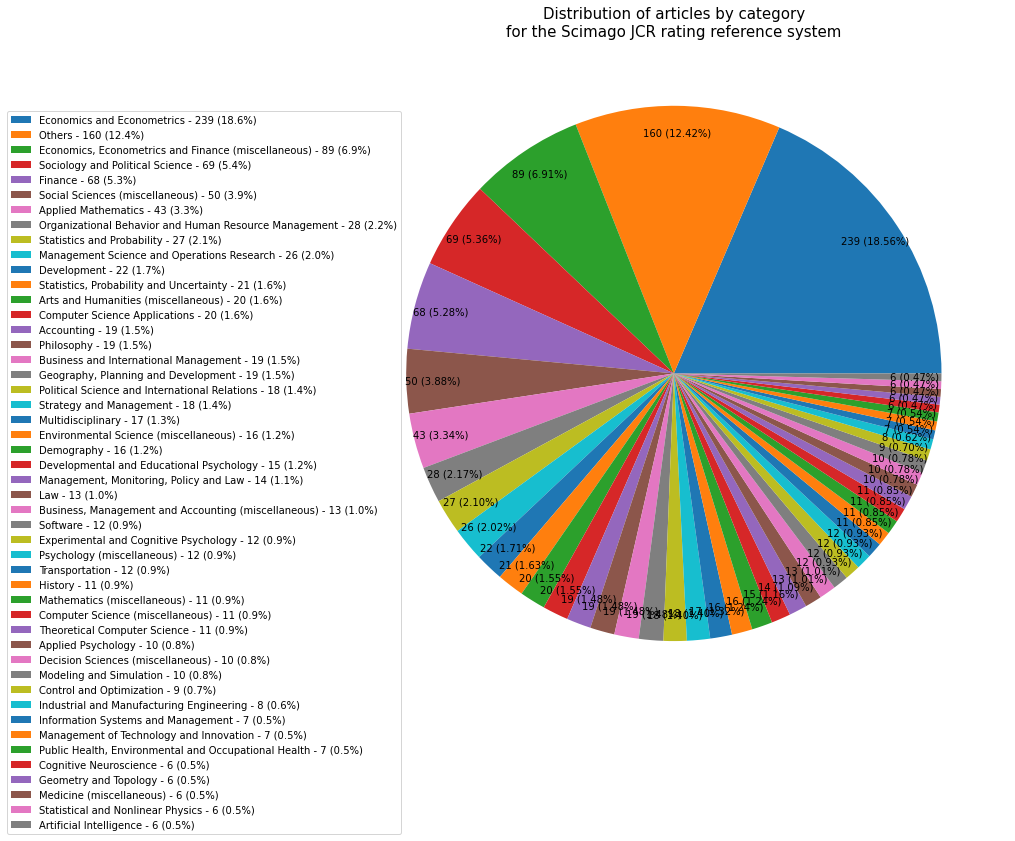

[2023-03-26 11:00:16][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_scimago_sjr_q_score_0.png"


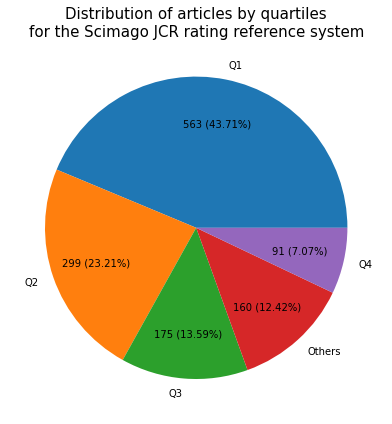

,uri_s,journalTitle_s,journalIssn_s,URL,ECONLIT,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,NUMBER_OF_REFERENTIALS
0,https://hal.science/hal-03534771,Zagadnienia Ekonomiki Rolnej / Problems of Agr...,0044-1600,NaN,False,False,NaN,NaN,False,0
1,https://hal.science/hal-03233310,Recherches Internationales,0294-3069,NaN,False,False,NaN,NaN,False,0
2,https://hal.science/hal-03205154,Finance Research Letters,1544-6123,NaN,False,False,Finance (Q1),Q1,True,1
3,https://hal-cnrs.archives-ouvertes.fr/hal-0390...,Recherches Internationales,0294-3069,NaN,False,False,NaN,NaN,False,0
4,https://hal.science/hal-03912939,Recherches Internationales,0294-3069,NaN,False,False,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...
755,https://hal.science/hal-03767916,World Development,0305-750X,http://www.sciencedirect.com/science/journal/0...,True,False,Development (Q1); Economics and Econometrics (...,Q1,True,2
756,https://hal.science/hal-02862765,The Journal of Risk,1465-1211,http://www.risk.net/type/journal/source/journa...,True,False,Finance (Q4); Strategy and Management (Q4),Q4,True,2
757,https://hal.science/hal-02865203,Demography,0070-3370,https://read.dukeupress.edu/demography/issue,True,False,Demography (Q1),Q1,True,2
758,https://hal.science/hal-02862823,Market microstructure and liquidity,2382-6266,NaN,False,False,NaN,NaN,False,0


In [63]:
ranking_df = rankings(
    dataframe = df_art,
    excludes = ['HCERES'],
    titles = {
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_hceres_matrix(dataframe=ranking_df)
scimago_rankings(
    dataframe=ranking_df,
    quantile=0.6,
    titles={
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    }
)
ranking_df

## Peer reviewing

[2023-03-26 11:00:16][INFO ][csv#35] Export to CSV file: ./exports/articles-peer-reviewing.csv (params: {'index': True}) (number of rows: 2)
[2023-03-26 11:00:16][INFO ][pie#127] Export pie graph to PNG file: ./exports/discribution_of_articles_with_peer_reviewing.png


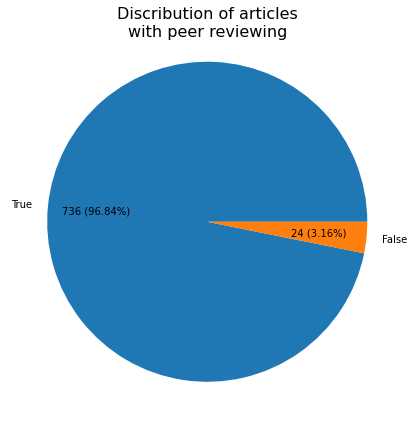

,peerReviewing_s,count
0,True,736
1,False,24


In [64]:
peer_reviewing = df_art[['uri_s', 'peerReviewing_s']].fillna(0).astype({'peerReviewing_s': 'int'})
peer_reviewing['peerReviewing_s'] = peer_reviewing.apply(func=lambda r: r['peerReviewing_s'] == 1, axis='columns')
DfOps(peer_reviewing) \
    .count(subset=['peerReviewing_s'], column='count') \
    .csv('articles-peer-reviewing.csv') \
    .pie(
        column='count',
        label_column='peerReviewing_s',
        title='Discribution of articles\nwith peer reviewing',
        plot_params=dict(figsize=(6,6), pctdistance=0.7),
        sort_params=dict(ascending=False)
    )

# Custom CES

## Producers on any kind of document

In [65]:
df_producers = df.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='inner',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s'],
)
df_producers = df_producers[['authLastName_s', 'authFirstName_s', 'authFullName_s', 'uri_s', 'POSTE']]
df_producers = df_producers.drop_duplicates(ignore_index=True)
DfOps(df_producers).count(subset=['POSTE'], column='count')

,POSTE,count
0,PERMANENT,1211
1,DOCTORANT,335
2,EMERITE,292
3,OTHERS,143
4,ASSOCIE,72


## Producers on articles

In [66]:
df_producers = df[df['docType_s'] == 'ART'].explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='inner',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s'],
)
df_producers = df_producers[['authLastName_s', 'authFirstName_s', 'authFullName_s', 'uri_s', 'POSTE']]
df_producers = df_producers.drop_duplicates(ignore_index=True)
DfOps(df_producers).count(subset=['POSTE'], column='count')

,POSTE,count
0,PERMANENT,639
1,EMERITE,132
2,DOCTORANT,108
3,OTHERS,77
4,ASSOCIE,25


## Nombre d'articles ayant au moins un permanent comme auteurs

[2023-03-26 11:00:17][INFO ][pie#127] Export pie graph to PNG file: ./exports/number_of_articles_having_at_least_one_permanent_as_an_author.png


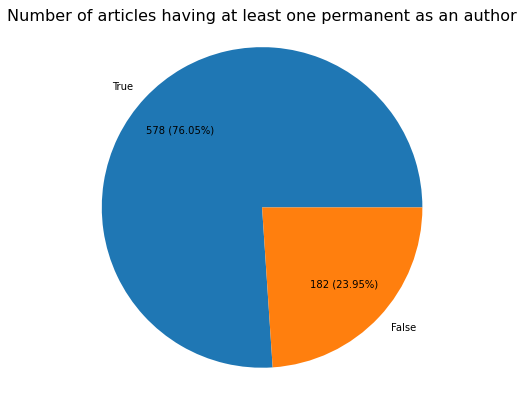

,IS_PERMANENT,count
0,True,578
1,False,182


In [67]:
permanent_articles = df[df['docType_s'] == 'ART'].explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='inner',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s'],
)
permanent_articles = permanent_articles[['authLastName_s', 'authFirstName_s', 'authFullName_s', 'uri_s', 'POSTE']]
permanent_articles['IS_PERMANENT'] = permanent_articles.apply(func=lambda r: r['POSTE'] == 'PERMANENT', axis='columns')
permanent_articles = permanent_articles[['uri_s', 'IS_PERMANENT']]

permanent_articles = permanent_articles.groupby(by=['uri_s']).agg({ 'IS_PERMANENT': lambda r: r.any() })

DfOps(permanent_articles) \
    .count(subset=['IS_PERMANENT'], column='count') \
    .pie(
        column='count',
        label_column='IS_PERMANENT',
        title='Number of articles having at least one permanent as an author',
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
        sort_params=dict(ascending=False),
    )

## Number of articles with peer reviewing comitee produces by permanent

[2023-03-26 11:00:17][INFO ][pie#127] Export pie graph to PNG file: ./exports/number_of_articles_with_peer_reviewing_produces_by_permanent_members.png


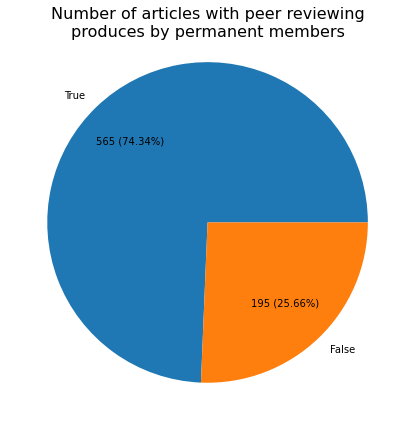

,PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING,count
0,True,565
1,False,195


In [68]:
permanent_peer_reviewing_articles = df[['uri_s', 'docType_s', 'peerReviewing_s', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]

# Filter on articles
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles[permanent_peer_reviewing_articles['docType_s'] == 'ART']
permanent_peer_reviewing_articles['peerReviewing_s'] = permanent_peer_reviewing_articles['peerReviewing_s'].fillna(0).astype('int')
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles.drop(columns=['docType_s'])

# Explode authors to merge it with extra_struct_authors
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='left',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

# Reject all POSTE that are not defined (not in CES)
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles[permanent_peer_reviewing_articles['POSTE'].notnull()].reset_index(drop=True)

permanent_peer_reviewing_articles['PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING'] = permanent_peer_reviewing_articles.apply(
    func=lambda r: r['peerReviewing_s'] if r['POSTE'] == 'PERMANENT' else 0,
    axis='columns'
)

permanent_peer_reviewing_articles = permanent_peer_reviewing_articles[['uri_s', 'PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING']]

#permanent_peer_reviewing_articles
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles.groupby(by=['uri_s']).agg({ 'PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING': lambda r: r.sum() > 0 })

DfOps(permanent_peer_reviewing_articles) \
    .count(subset=['PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING'], column='count') \
    .pie(
        column='count',
        label_column='PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING',
        title='Number of articles with peer reviewing\nproduces by permanent members',
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
        sort_params=dict(ascending=False),
    )

## Number of articles of Ranking A HCERES produces by permanent

[2023-03-26 11:00:17][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['HCERES'] (excludes=['ECONLIT', 'MATHSCINET', 'SCIMAGO'])
[2023-03-26 11:00:17][INFO ][pie#127] Export pie graph to PNG file: ./exports/articles_of_rank_a_in_hceres_ranking_system_procudes_py_permanent.png


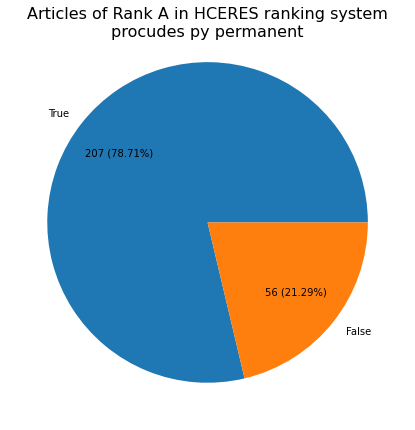

,BY_PERMANENT,count
0,True,207
1,False,56


In [69]:
# Create dataframe with HCERES Ranking
permanent_rank_a_hceres_articles = create_ranking_journals_df(dataframe=df, excludes=['ECONLIT', 'MATHSCINET', 'SCIMAGO'])

# Merge with original DataFrame and filter on articles
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles.merge(df, how='left', on=['uri_s'])
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[permanent_rank_a_hceres_articles['docType_s'] == 'ART']

# Keep required columns
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[['uri_s', 'HCERES_RANK', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]

# Explode authors to merge it with extra_struct_authors
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='left',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

# Drop POSTE having null => not in CES
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[permanent_rank_a_hceres_articles['POSTE'].notnull()]

# Keep required columns and create new columns for RANK_A By PERMANENT
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[['uri_s', 'HCERES_RANK', 'POSTE']]

# Filter only on article with A ranking in HCERES System
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[permanent_rank_a_hceres_articles['HCERES_RANK'] == 'A']

# Create a new columns to identify permanent
permanent_rank_a_hceres_articles['BY_PERMANENT'] = permanent_rank_a_hceres_articles.apply(func=lambda r: r['POSTE'] == 'PERMANENT', axis='columns')

# Drop columns, group by uri and aggregate
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles \
    .drop(columns=['HCERES_RANK', 'POSTE']) \
    .groupby(by=['uri_s']) \
    .agg({'BY_PERMANENT': lambda r: r.any() }).reset_index()

DfOps(permanent_rank_a_hceres_articles) \
    .count(subset=['BY_PERMANENT'], column='count') \
    .pie(
        column='count',
        label_column='BY_PERMANENT',
        title='Articles of Rank A in HCERES ranking system\nprocudes py permanent',
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
        sort_params=dict(ascending=False),
    )

## Pourcentage de permanents sans articles a comité de lecture

,uri_s,docType_s,peerReviewing_s,POSTE,LASTNAME,FIRSTNAME
0,https://hal.science/hal-03233310,ART,1,PERMANENT,HERRERA,Remy
1,https://hal-cnrs.archives-ouvertes.fr/hal-0390...,ART,1,PERMANENT,HERRERA,Remy
2,https://hal.science/hal-03503929,ART,1,PERMANENT,HERRERA,Remy
3,https://hal.science/hal-03233272,ART,1,PERMANENT,HERRERA,Remy
4,https://hal.science/hal-03233297,ART,1,PERMANENT,HERRERA,Remy
...,...,...,...,...,...,...
688,0,0,0,PERMANENT,SAUCET,Charlotte
689,0,0,0,PERMANENT,TOURE,Nouhoum
690,0,0,0,PERMANENT,VERDUGO,Gregory
691,0,0,0,PERMANENT,VORNETTI,Patricia


[2023-03-26 11:00:17][INFO ][csv#35] Export to CSV file: ./exports/ces-permanents-without-articles-with-peer-reviewing.csv (params: {'index': False}) (number of rows: 693)
[2023-03-26 11:00:17][INFO ][pie#127] Export pie graph to PNG file: ./exports/number_of_permanent_with_at_least_one_article_with_peer_reviewing.png


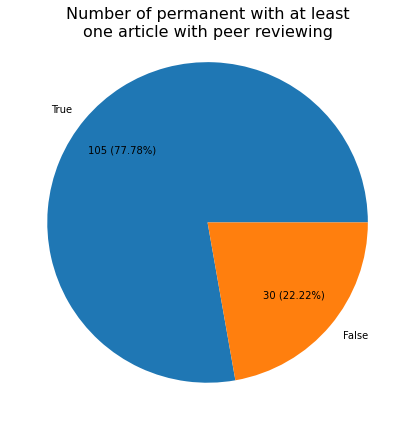

,HAS_ARTICLES_WITH_PEER_REVIEWING,count
0,True,105
1,False,30


In [70]:
# Filter on articles and explode authors
permanent_without_peer_reviewing_articles = df[['uri_s', 'docType_s', 'peerReviewing_s', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles[permanent_without_peer_reviewing_articles['docType_s'] == 'ART']
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s'])

# Merge with extra struct authors
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.merge(
    extra_struct_authors,
    how='outer',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

# Filter on permanents
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles[permanent_without_peer_reviewing_articles['POSTE'] == 'PERMANENT']
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.drop(columns=['authLastName_s', 'authFirstName_s', 'authFullName_s'])
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.reset_index(drop=True)

permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.fillna(0).astype({'peerReviewing_s': int})
DfOps(permanent_without_peer_reviewing_articles).display().csv('ces-permanents-without-articles-with-peer-reviewing.csv', index=False)

# Group by Lastname + Fistname
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.groupby(['LASTNAME', 'FIRSTNAME']) \
    .agg({ 'peerReviewing_s': lambda x: x.dropna().sum() > 0 }) \
    .rename(columns={'peerReviewing_s': 'HAS_ARTICLES_WITH_PEER_REVIEWING'}) \
    .reset_index()

# Count, diagrams and display
DfOps(permanent_without_peer_reviewing_articles) \
    .count(subset=['HAS_ARTICLES_WITH_PEER_REVIEWING'], column='count') \
    .pie(
        column='count',
        label_column='HAS_ARTICLES_WITH_PEER_REVIEWING',
        title='Number of permanent with at least\none article with peer reviewing',
        plot_params=dict(pctdistance=0.7, figsize=(6, 6), ),
        sort_params=dict(ascending=False)
    )

## Pourcentage de permanents sans aucun travaux

[2023-03-26 11:00:17][INFO ][csv#35] Export to CSV file: ./exports/ces-number-of-work-by-permanent.csv (params: {'index': False}) (number of rows: 135)
[2023-03-26 11:00:17][INFO ][pie#127] Export pie graph to PNG file: ./exports/number_of_works_by_permanent.png


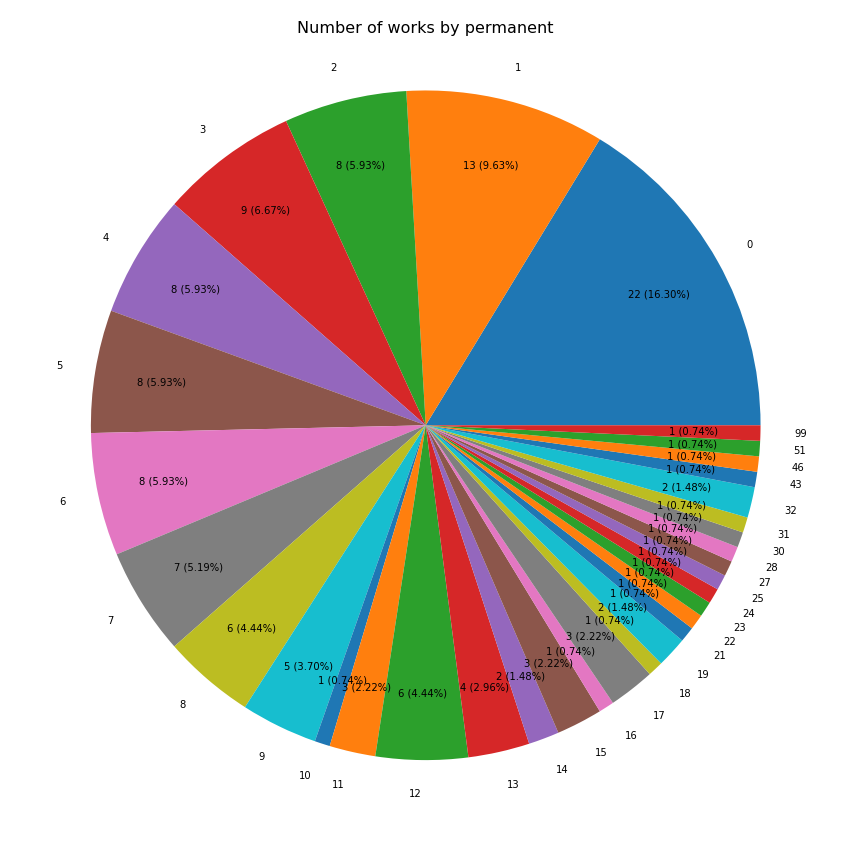

,NUMBER_OF_WORKS,count
0,0,22
1,1,13
3,2,8
2,3,9
4,4,8
5,5,8
6,6,8
7,7,7
8,8,6
10,9,5


In [71]:
permanent_without_any_works = df[['uri_s', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]

# Merge with extra struct authors
permanent_without_any_works = permanent_without_any_works.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='outer',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

permanent_without_any_works = permanent_without_any_works[permanent_without_any_works['POSTE'] == 'PERMANENT'].reset_index(drop=True)
permanent_without_any_works = permanent_without_any_works.drop(columns=['authLastName_s', 'authFirstName_s', 'authFullName_s'])

permanent_without_any_works['NUMBER_OF_WORKS'] = permanent_without_any_works.apply(func=lambda r: 1 if pd.notnull(r['uri_s']) else 0, axis='columns')

# Keep only required columns, group by FIRSTNAME & LASTNAME and sum
permanent_without_any_works = permanent_without_any_works.drop(columns=['uri_s', 'POSTE']).groupby(by=['LASTNAME', 'FIRSTNAME']).sum().reset_index()

permanent_without_any_works = permanent_without_any_works.sort_values(by=['NUMBER_OF_WORKS'])

DfOps(permanent_without_any_works) \
    .csv('ces-number-of-work-by-permanent.csv', index=False) \
    .count(subset=['NUMBER_OF_WORKS'], column='count') \
    .pie(
        column='count',
        label_column='NUMBER_OF_WORKS',
        title='Number of works by permanent',
        sort_by='NUMBER_OF_WORKS',
        title_params={'y': 1.0, 'pad': -26}
    )